In [14]:
from sympy import symbols, diff
import math
import time
import numba
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from dotPlacer import DotPlacer
import cv2
import concurrent.futures

def loadingBar(percent, length):
    percent = float(percent)
    length = float(length)
    numOfSpaces = int(str(percent/(100/length)).split('.')[0])
    numofnoSpaces = length - numOfSpaces
    x = 0
    shadedSpaces = []
    nonShadedSpaces = []
    while x != numOfSpaces:
        x = x + 1
        shadedSpaces.append(' ')
        
    x = 0
    while x != numofnoSpaces:
        x = x + 1
        nonShadedSpaces.append(' ')
        
    shadedSpaces = ''.join(shadedSpaces)
    nonShadedSpaces = ''.join(nonShadedSpaces)
    progressBar = '|' + '\x1b[0;31;41m' + shadedSpaces + '\x1b[0m'+ nonShadedSpaces +'|' + str(int(percent)) + '%'
    return progressBar

class Timer:
    def __init__(self):
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def stop(self, label="Execution Time"):
        if self.start_time is None:
            raise RuntimeError("Timer was not started. Call 'start()' before stopping.")
        elapsed_time = time.time() - self.start_time
        print(f"{label}: {elapsed_time:.6f} seconds")
        self.start_time = None  # Reset timer

def Calc_centroid(p1, p2, p3, p4):
    x = (p1[0]+p2[0]+p3[0]+p4[0])/4
    y = (p1[1]+p2[1]+p3[1]+p4[1])/4
    return x, y

def F(transposed, origin):
    a1_2 = math.sqrt(((origin[1][0] - origin[0][0]) ** 2) + ((origin[1][1] - origin[0][1]) ** 2)) / 2
    a4_3 = math.sqrt(((origin[2][0] - origin[3][0]) ** 2) + ((origin[2][1] - origin[3][1]) ** 2)) / 2
    b4_1 = math.sqrt(((origin[3][1] - origin[0][1]) ** 2) + ((origin[3][0] - origin[0][0]) ** 2)) / 2
    b2_3 = math.sqrt(((origin[2][1] - origin[1][1]) ** 2) + ((origin[2][0] - origin[1][0]) ** 2)) / 2

    x, y = symbols('x y', real=True)

    u = (transposed[0][0]-origin[0][0])*(1/(4*a1_2*b4_1))*(x-origin[1][0])*(y-origin[3][1]) + (transposed[1][0]-origin[1][0])*(-1*(1/(4*a1_2*b2_3))*(x-origin[0][0])*(y-origin[2][1])) + (transposed[2][0]-origin[2][0])*(1/(4*a4_3*b2_3))*(x-origin[3][0])*(y-origin[1][1]) + (transposed[3][0]-origin[3][0])*(-1*(1/(4*a4_3*b4_1))*(x-origin[2][0])*(y-origin[0][1]))

    v = (transposed[0][1]-origin[0][1])*(1/(4*a1_2*b4_1))*(x-origin[1][0])*(y-origin[3][1]) + (transposed[1][1]-origin[1][1])*(-1*(1/(4*a1_2*b2_3))*(x-origin[0][0])*(y-origin[2][1])) + (transposed[2][1]-origin[2][1])*(1/(4*a4_3*b2_3))*(x-origin[3][0])*(y-origin[1][1]) + (transposed[3][1]-origin[3][1])*(-1*(1/(4*a4_3*b4_1))*(x-origin[2][0])*(y-origin[0][1]))

    #u(x, y) = function of x & y returns relative x displacment in element
    #v(x, y) = function of x & y returns relative y displacment in element
    #tx, ty = Calc_centroid(transposed[0], transposed[1], transposed[2], transposed[3])
    tx, ty = Calc_centroid(origin[0], origin[1], origin[2], origin[3])

    xx = float(diff(u, x).replace(y, ty))
    xy = float(diff(u, y).replace(x, tx))
    yx = float(diff(v, x).replace(y, ty))
    yy = float(diff(v, y).replace(x, tx))

    #F = np.matrix([[xx, xy], [yx, yy]])
    F = [[xx, xy], [yx, yy]]
    return F, [tx, ty]

timer = Timer()
timer.start()
class Snippet:
    def __init__(self, initContourDetails):
        (x, y), (x2, y2) = initContourDetails
        w, h = x2 - x, y2 - y
        initial_pos = (x + w // 2, y + h // 2)
        self.positions = []  # List of (x, y) tuples
        self.bounding_box = (x, y, w, h)  # Store bounding box for reference
        self.snippet = None  # Placeholder for image snippet
        self.id = 0
        self.row = 0
        self.col = 0
        self.center = initial_pos
    def update_position(self, new_pos):
        self.positions.append(new_pos)
    def find_dot_center_otsu(self):
        img_gray = cv2.cvtColor(self.snippet, cv2.COLOR_BGR2GRAY)
        threshold_value, binary = cv2.threshold(
            img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )
        
        y_coords, x_coords = np.where(binary == 255)
        
        if len(x_coords) > 0:
            center_x = np.mean(x_coords)
            center_y = np.mean(y_coords)
            self.center = (self.bounding_box[0] + round(center_x), self.bounding_box[1] + round(center_y))
            
        return binary
        

    def extract_snippet(self, img):   
        x, y, w, h = self.bounding_box 
        y1, y2 = y, y + h
        x1, x2 = x, x + w
        self.snippet = img[y1:y2, x1:x2]
        return self.snippet

VIDEOPATH = r"C:\Users\deniz\Coding\Digital-Image-Correlation-Remastered\videos\deform_vice4.mp4"
subsectionSize = 80 #in pixels
maxFrames = 124

cap = cv2.VideoCapture(VIDEOPATH)
ret, frame = cap.read()
untouched_frame = frame.copy()
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

size = (frame_width, frame_height)
timer.stop("Video Load Time")
dotPickerUI = input("Would you like to use saved dot positions? (y/n): ").strip().lower()
#dotPickerUI = 'y'
timer.start()
if dotPickerUI == 'y':
    with open(r"C:\Users\deniz\Coding\Digital-Image-Correlation-Remastered\patternTracking\savedDots.txt", 'r') as f:
        lines = f.readlines()
        coordinates = []
        for line in lines:
            x, y = map(float, line.strip().split(','))
            coordinates.append((x, y))
else:
    placer = DotPlacer(frame, dot_radius=10)
    placer.show()

    coordinates = placer.get_coordinates()
    with open(r"C:\Users\deniz\Coding\Digital-Image-Correlation-Remastered\patternTracking\savedDots.txt", 'w') as f:
        for x, y in coordinates:
            f.write(f"{x},{y}\n")
print("\nFinal dot coordinates:")
for i, (x, y) in enumerate(coordinates, 1):
    print(f"Dot {i}: ({x:.2f}, {y:.2f})")

# Finding tl, tr, br, bl
tl, tr, br, bl = None, None, None, None
lowest_sum = float('inf')
highest_sum = float('-inf')
for dot in coordinates:
    if dot[0] + dot[1] < lowest_sum:
        lowest_sum = dot[0] + dot[1]
        tl = dot
    if dot[0] + dot[1] > highest_sum:
        highest_sum = dot[0] + dot[1]
        br = dot
coordinates.remove(tl)
coordinates.remove(br)
if coordinates[0][0] < coordinates[1][0]:
    tr = coordinates[1]
    bl = coordinates[0]
else:
    tr = coordinates[0]
    bl = coordinates[1]

lowestTop = max([tr, tl], key=lambda x: x[1])[1]
highestBottom = min([bl, br], key=lambda x: x[1])[1]
rightMostLeft = max([tl, bl], key=lambda x: x[0])[0]
leftMostRight = min([tr, br], key=lambda x: x[0])[0]
print(f"Top Left: {tl}, Top Right: {tr}, Bottom Right: {br}, Bottom Left: {bl}")
print(f"Lowest Top: {lowestTop}, Highest Bottom: {highestBottom}, Right Most Left: {rightMostLeft}, Left Most Right: {leftMostRight}")
cv2.circle(frame, (int(tl[0]), int(tl[1])), 5, (255, 0, 0), -1)
cv2.circle(frame, (int(tr[0]), int(tr[1])), 5, (0, 255, 0), -1)
cv2.circle(frame, (int(br[0]), int(br[1])), 5, (0, 0, 255), -1)
cv2.circle(frame, (int(bl[0]), int(bl[1])), 5, (0, 255, 255), -1)
tr, tl, bl, br = (int(leftMostRight), int(lowestTop)), (int(rightMostLeft), int(lowestTop)), (int(rightMostLeft), int(highestBottom)), (int(leftMostRight), int(highestBottom))
cv2.rectangle(frame, (int(leftMostRight), int(lowestTop)), (int(rightMostLeft), int(highestBottom)), (0, 255, 0), 2)
cv2.circle(frame, (int(tl[0]), int(tl[1])), 5, (255, 0, 0), -1)
cv2.circle(frame, (int(tr[0]), int(tr[1])), 5, (0, 255, 0), -1)
cv2.circle(frame, (int(br[0]), int(br[1])), 5, (0, 0, 255), -1)
cv2.circle(frame, (int(bl[0]), int(bl[1])), 5, (0, 255, 255), -1)
if dotPickerUI != 'y':
    cv2.imshow("Image with Rectangle", frame)
    cv2.waitKey(0)

# Each rectangle is repersented as a tuple of it's top left corner and bottom right corner
# intervalx = tl[0] - tr[0] // subsectionSize
# intervaly = tl[0] - bl[0] // subsectionSize

xValues = [x for x in range(tl[0], tr[0], subsectionSize)]
if tr[0] - xValues[-1] > int(2*(subsectionSize // 3)):
    #xValues = xValues[:-1]
    xValues.append(br[0])
yValues = [x for x in range(tl[1], bl[1], subsectionSize)]
if bl[1] - yValues[-1] > int(2*(subsectionSize // 3)):
    #yValues = yValues[:-1]
    yValues.append(bl[1])

SNIPPETSHAPE = (len(yValues)-1, len(xValues)-1)

rectangles = np.empty((len(xValues) - 1, len(yValues) - 1), dtype=object)
for i in range(len(xValues) -1):
    for j in range(len(yValues)-1):
        cv2.rectangle(frame, (xValues[i], yValues[j]), (xValues[i+1], yValues[j+1]), (255, 0, 0), 1)
        rectangles[i, j] = Snippet(((xValues[i], yValues[j]), (xValues[i+1], yValues[j+1])))
        rectangles[i, j].id = int(j*SNIPPETSHAPE[1] + i+1)
        rectangles[i, j].row = j
        rectangles[i, j].col = i
        rectangles[i, j].extract_snippet(untouched_frame)
        rectangles[i, j].update_position(rectangles[i, j].center)
        cv2.putText(frame, str(rectangles[i, j].id), (xValues[i]+5, yValues[j]+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
resized_frame = cv2.resize(frame, (size[0] // 2, size[1] // 2))
rectangles = rectangles.T
#cv2.imshow("Image with Rectangle", resized_frame)
timer.stop("Dot Placement and Snippet Extraction Time")
i  =0
IMSHOW = True

timer.start()
while cap.isOpened():
    ret, newFrame = cap.read()
    print(loadingBar((i / (maxFrames if maxFrames != None else total_frames)) * 100, 50), end="\r")
    #time.sleep(1)
    img= cv2.cvtColor(newFrame, cv2.COLOR_BGR2GRAY)
    assert img is not None, "file could not be read, check with os.path.exists()"
    if maxFrames != None and i == maxFrames:
        break
    method = getattr(cv, "TM_CCOEFF_NORMED")

    def templateMatching(rectangle):
        snippet = rectangle.snippet
        template = cv2.cvtColor(snippet, cv2.COLOR_BGR2GRAY)
        assert template is not None, "file could not be read, check with os.path.exists()"
        w, h = template.shape[::-1]

        cx, cy = rectangle.positions[-1][0], rectangle.positions[-1][1]
        # y1, y2 = cy - h, cy + h
        # x1, x2 = cx - w, cx + w
        # imgSnippet = img[y1:y2, x1:x2]
        res = cv.matchTemplate(img,template,method)
        # min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        flat = res.flatten()
        top5_idx = np.argpartition(flat, -5)[-5:]
        top5_idx = top5_idx[np.argsort(flat[top5_idx])[::-1]]
        wRes, _ = res.shape[1], res.shape[0]
        top5_locs = [(idx % wRes, idx // wRes) for idx in top5_idx]
        max_loc = top5_locs[0]
        for loc in top5_locs:
            dist = np.sqrt((loc[0] - cx)**2 + (loc[1] - cy)**2)
            if dist < np.sqrt((max_loc[0] - cx)**2 + (max_loc[1] - cy)**2):
                max_loc = loc

        top_left = max_loc

        bottom_right = (top_left[0] + w, top_left[1] + h)
        rectangle.update_position((max_loc[0] + w // 2, max_loc[1] + h // 2))
        if IMSHOW:
            cv2.circle(newFrame, (max_loc[0] + w // 2, max_loc[1] + h // 2), 5, (0, 0, 255), -1)
            cv2.rectangle(newFrame,top_left, bottom_right, 0, 2)
        

        return res
    # for r in rectangles.flatten():
    #     templateMatching(r.snippet)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(templateMatching, rectangles.flatten())
    if IMSHOW:
        resized_frame = cv2.resize(newFrame, (size[0] // 2, size[1] // 2))
        cv2.imshow("Image with Tracking", resized_frame)
    if IMSHOW and cv2.waitKey(25) & 0xFF == ord('q'):
        break
    i += 1




timer.stop("Total Tracking Time")

Video Load Time: 0.046732 seconds


Would you like to use saved dot positions? (y/n):  y



Final dot coordinates:
Dot 1: (1028.87, 362.98)
Dot 2: (1032.58, 730.88)
Dot 3: (636.82, 703.01)
Dot 4: (646.11, 407.58)
Top Left: (646.1064516129032, 407.57741935483864), Top Right: (1028.867741935484, 362.98387096774184), Bottom Right: (1032.583870967742, 730.8806451612902), Bottom Left: (636.8161290322581, 703.0096774193548)
Lowest Top: 407.57741935483864, Highest Bottom: 703.0096774193548, Right Most Left: 646.1064516129032, Left Most Right: 1028.867741935484
Dot Placement and Snippet Extraction Time: 0.004156 seconds
Total Tracking Time: 22.224995 seconds                       |100%


In [40]:
rows, cols = rectangles.shape

squares = []
for r in range(rows - 1):
    for c in range(cols - 1):
        square = [rectangles[r, c], rectangles[r, c+1], rectangles[r+1, c], rectangles[r+1, c+1]]
        squares.append(square)
print(f"Total squares: {len(squares)}")
strainInFrames = [] # frames, squares, ([[xx, xy], [yx, yy]], (cx, cy))
# list[list[tuple[list[list[float]], tuple[float, float]]]]

for frame in range(1, maxFrames):
    squaresInFrame = []
    for i, square in enumerate(squares):
        tl, tr, bl, br = square
        # all points are going to be ordered tl, tr, br, bl
        ORIGIN = [tl.positions[frame-1], tr.positions[frame-1], br.positions[frame-1], bl.positions[frame-1]]
        TRANSPOSED = [tl.positions[frame], tr.positions[frame], br.positions[frame], bl.positions[frame]]
        F_matrix, centroid = F(TRANSPOSED, ORIGIN)
        squaresInFrame.append((F_matrix, centroid))
    strainInFrames.append(squaresInFrame)


Total squares: 12


In [45]:
# Strain for the first square
firstSquare = [strainInFrames[x][0][0] for x in range(len(strainInFrames))]
xx, xy, yx, yy = 0, 0, 0, 0
for frame in firstSquare:
    xx += frame[0][0]
    xy += frame[0][1]
    yx += frame[1][0]
    yy += frame[1][1]
    print(xx)


0.0
0.0
0.006288574181784745
0.006365719959222379
0.006442862063842971
0.00023192486711138237
0.006481924867111374
0.00030956755751828345
0.00030956755751828345
0.01280956755751828
0.01280956755751828
0.00046388854517260235
0.006713888545172594
0.01296340032113561
0.01296340032113561
0.01311770954965647
0.01311770954965647
0.013040054558326538
0.019251489326634875
0.013192488640691065
0.013192488640691065
0.0194039234089994
0.01947820227450372
0.019553969254699148
0.019553969254699148
0.007284506689287356
0.013573068546994357
0.01970685446391966
0.01978262144411509
0.025916371368496668
0.025916371368496668
0.013722676778155115
0.02606686797180205
0.02606686797180205
0.02606686797180205
0.02606686797180205
0.026066836991435756
0.026066836991435756
0.02606678019913445
0.02621346208286752
0.02621346208286752
0.032349149487400065
0.03242256822734677
0.03242256822734677
0.03249603205402358
0.026472418233178426
0.0325313870507147
0.0325313870507147
0.026470079973281845
0.03252753558581691
0.

In [49]:
Elements = [[square[0] for square in frame] for frame in strainInFrames]
Centroids = [[square[1] for square in frame] for frame in strainInFrames]

thingi = []
# for i in Elements:
#     print(i[0][1][1])

master = []
for i in Elements:
    for x in i:
        #what strain direction
        master.append(round(x[0][0], 6))

print()
#smallest_strain = np.percentile(master, 80)
#largest_strain = np.percentile(master, 20)
smallest_strain = min(master)
largest_strain = max(master)
#smallest_strain = -0.028964
#largest_strain = 0.027823
print(smallest_strain, largest_strain)


-0.019647 0.017856


2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


C:\Users\deniz\AppData\Local\Temp\ipykernel_18884\1834288433.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


NameError: name 'Distance' is not defined

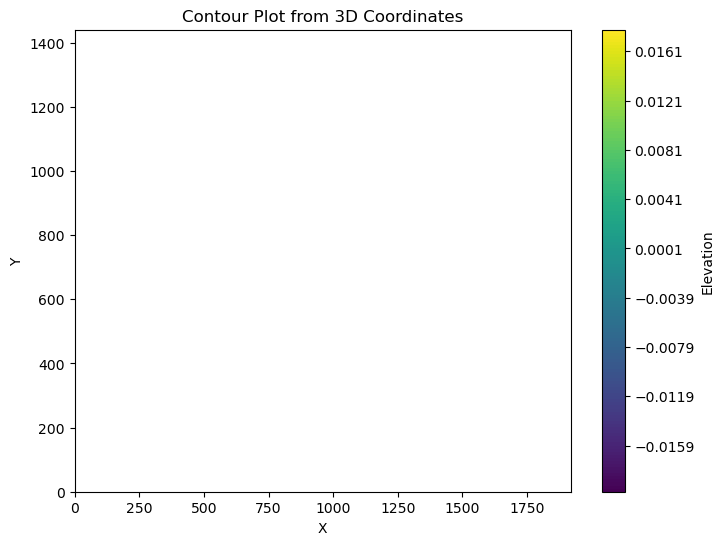

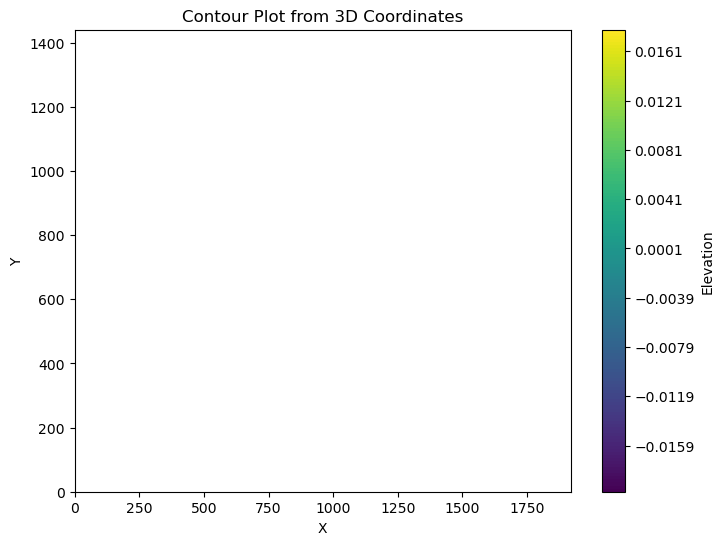

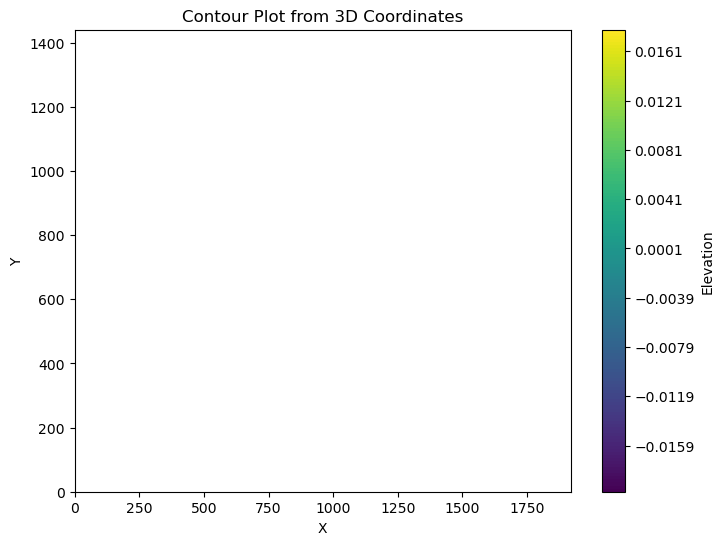

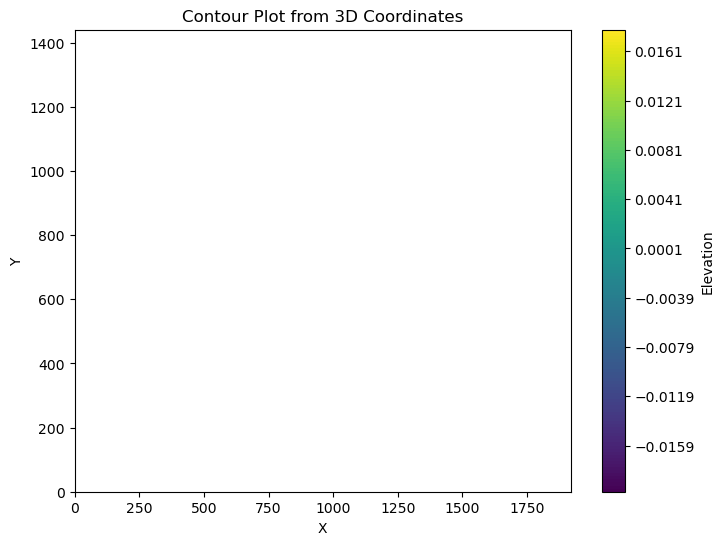

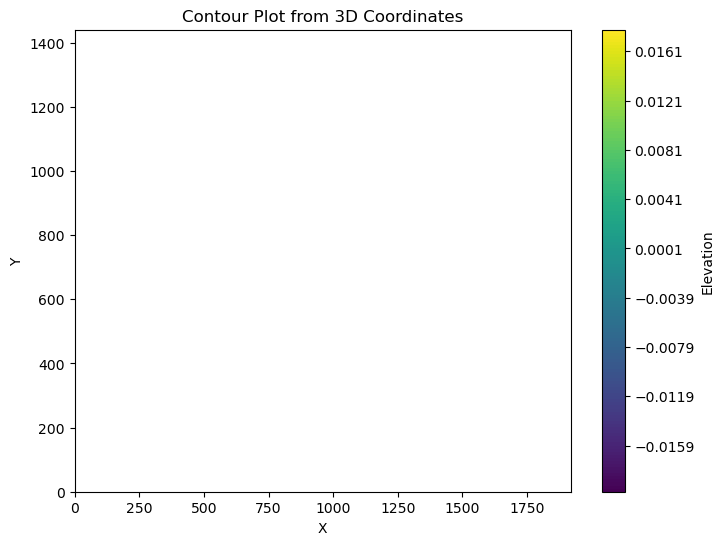

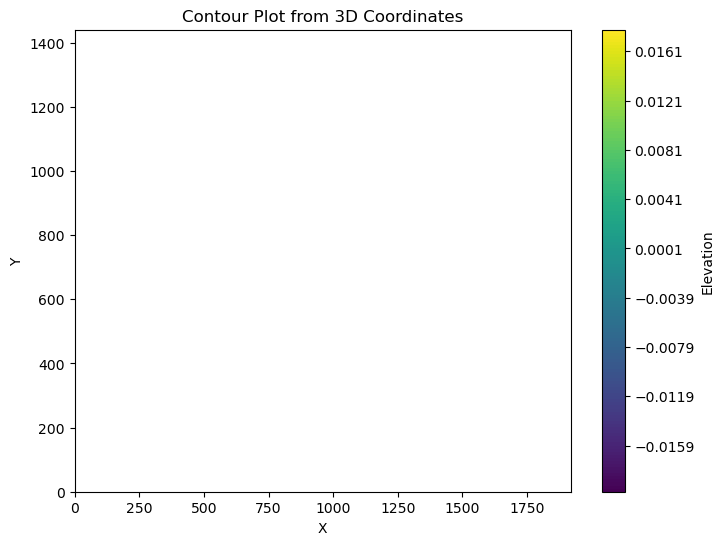

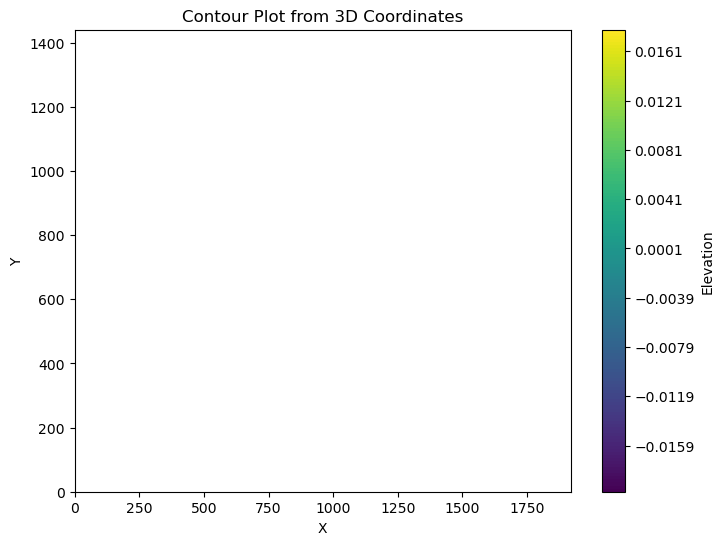

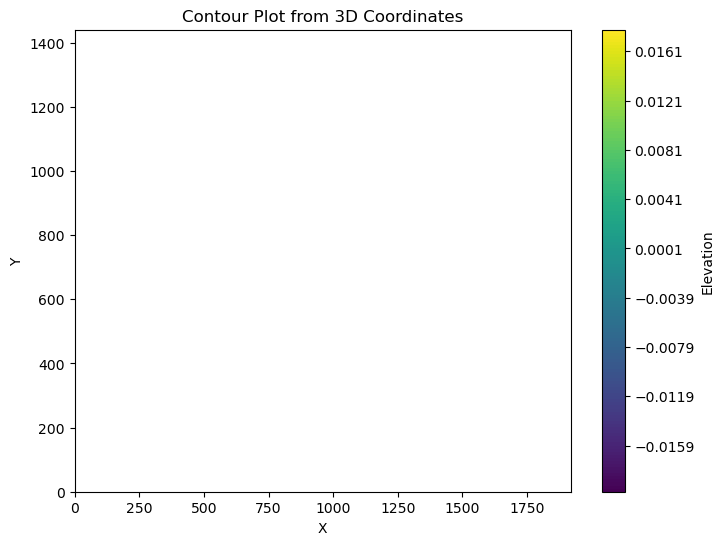

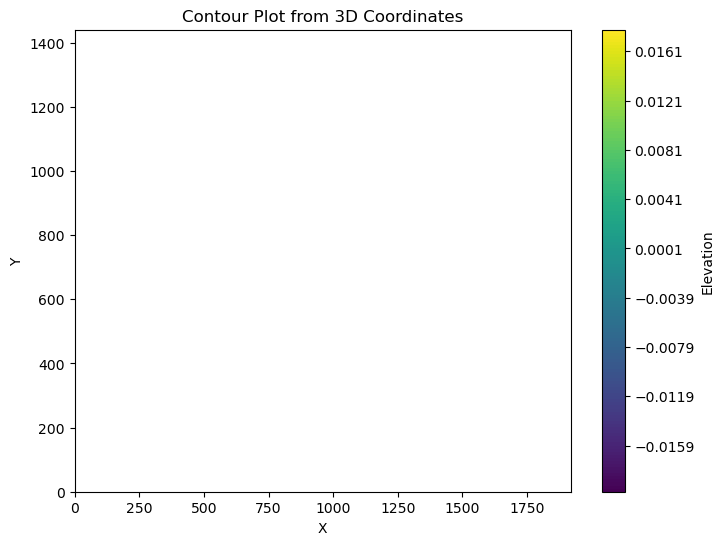

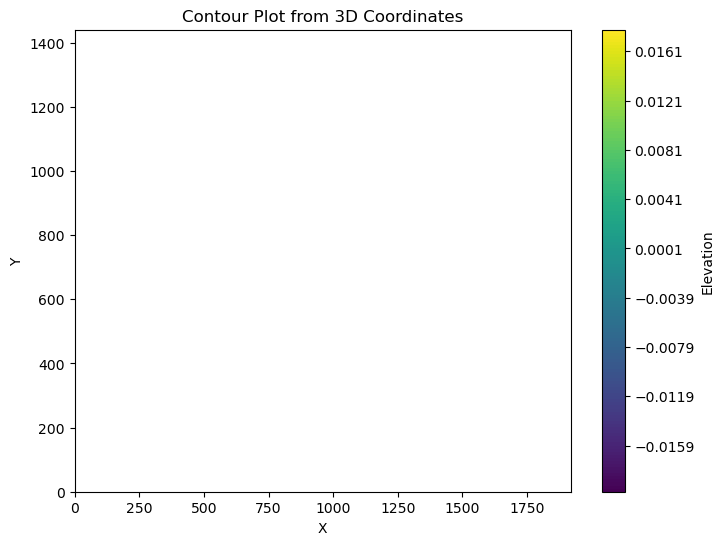

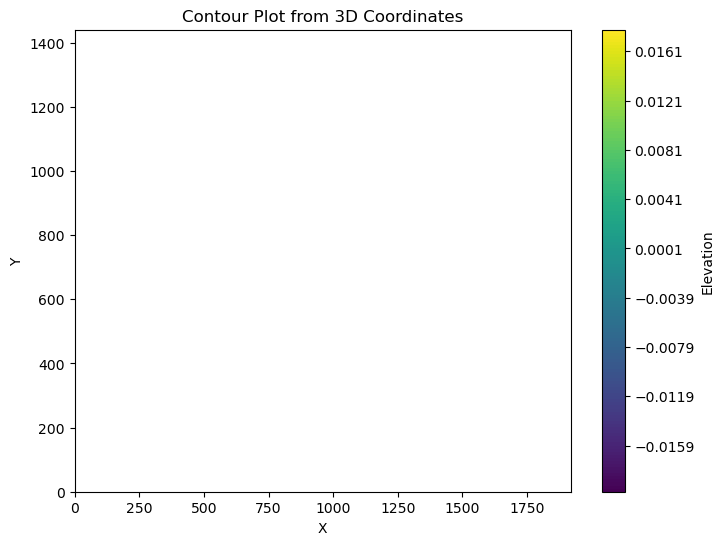

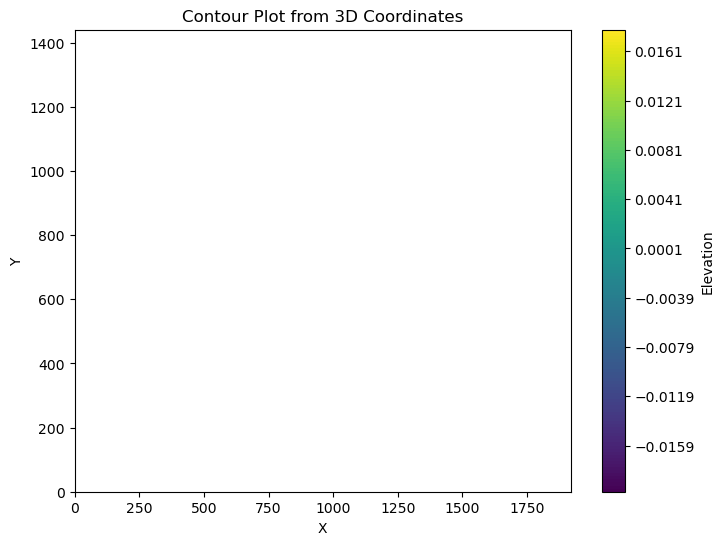

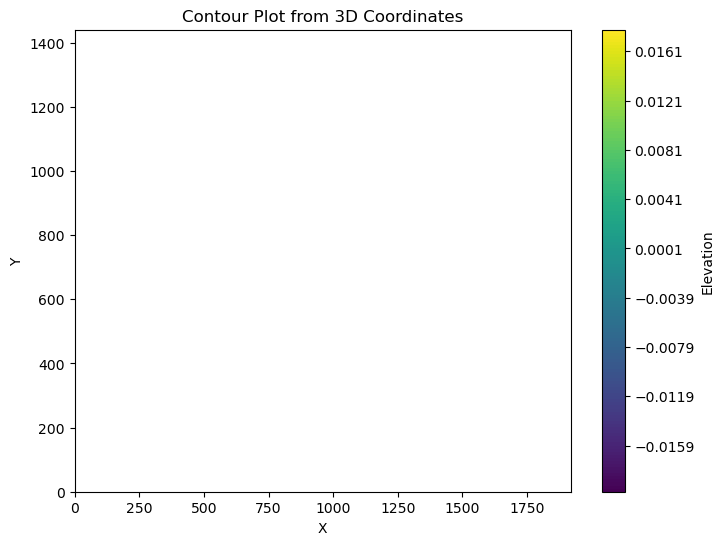

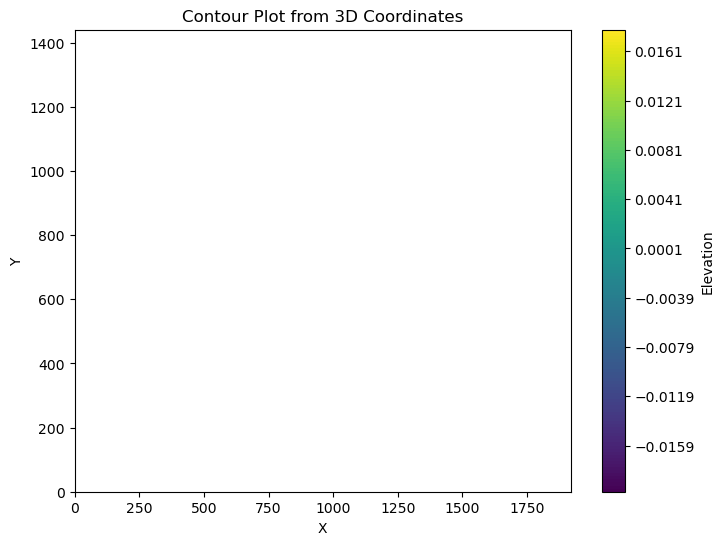

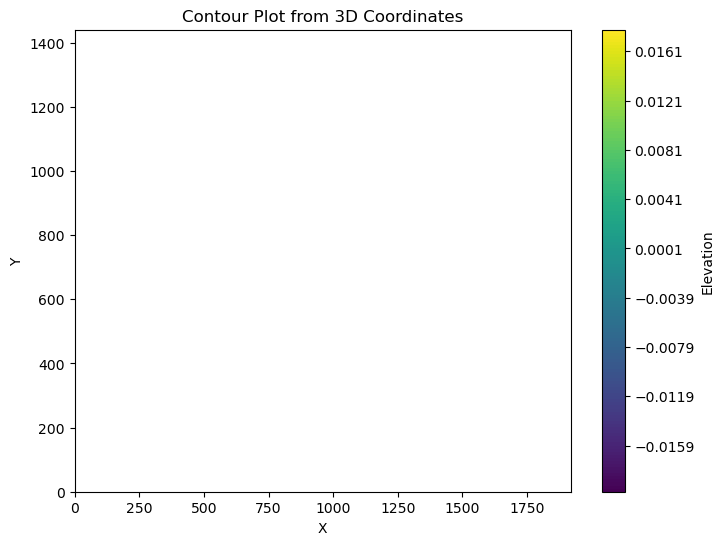

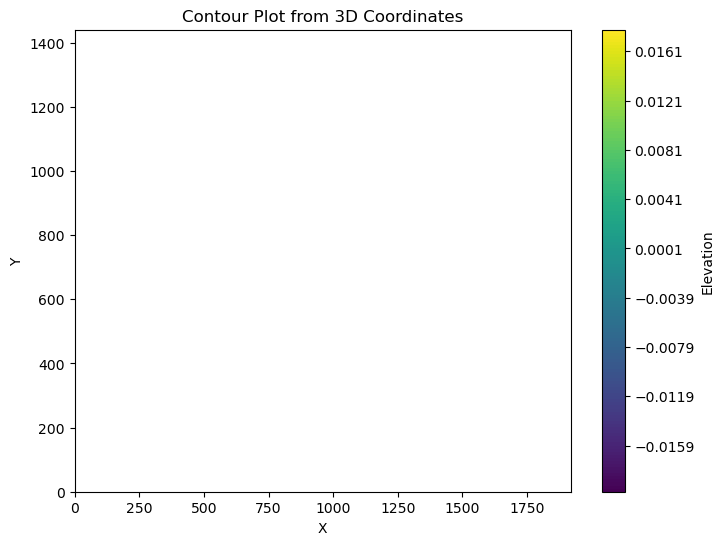

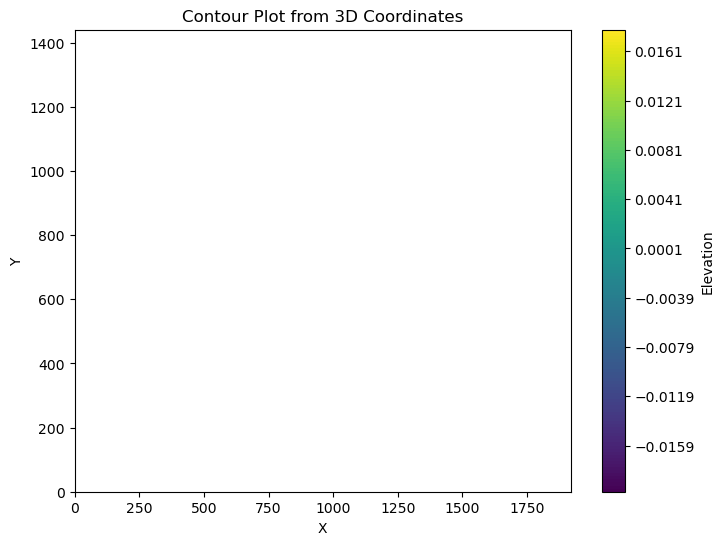

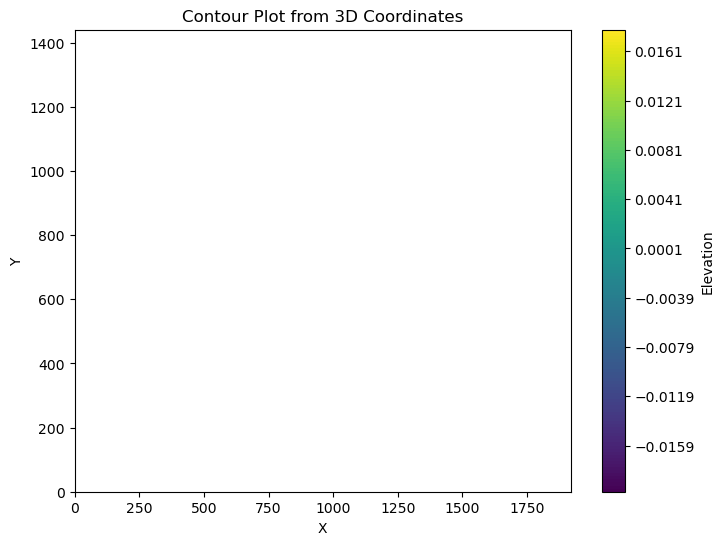

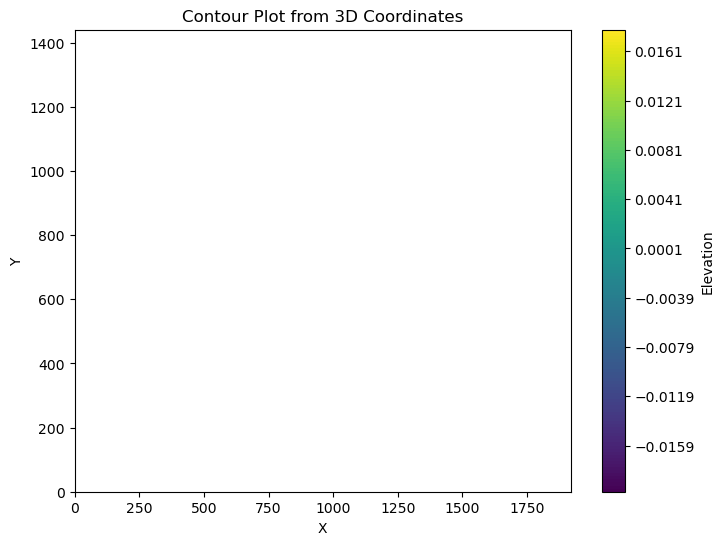

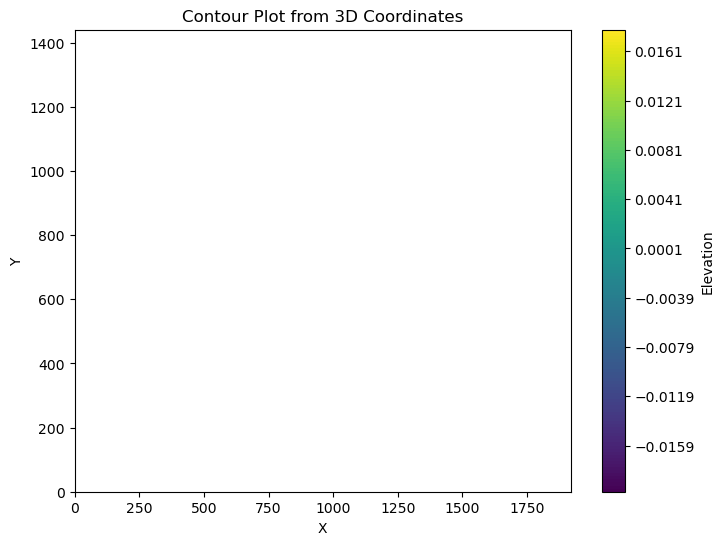

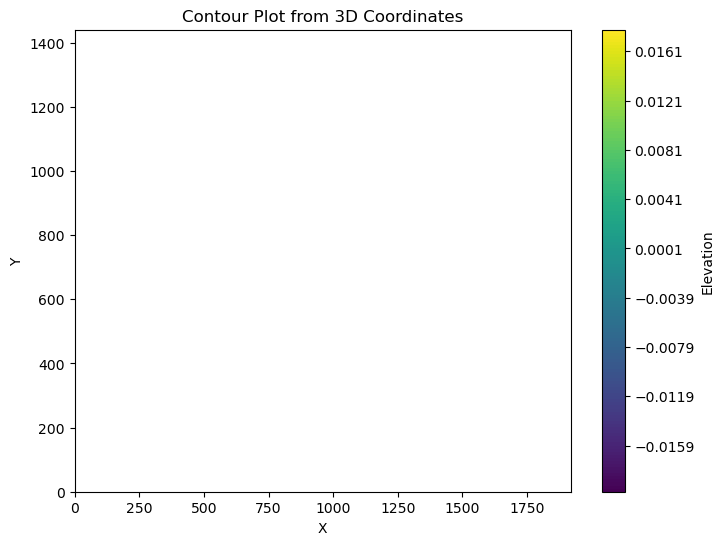

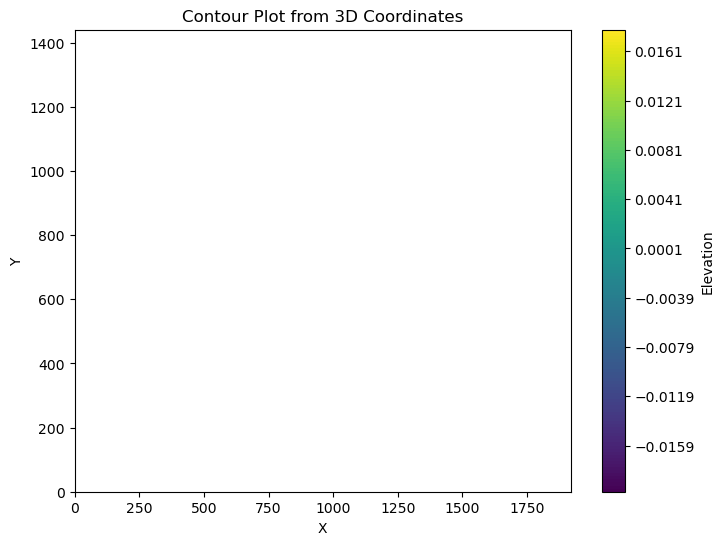

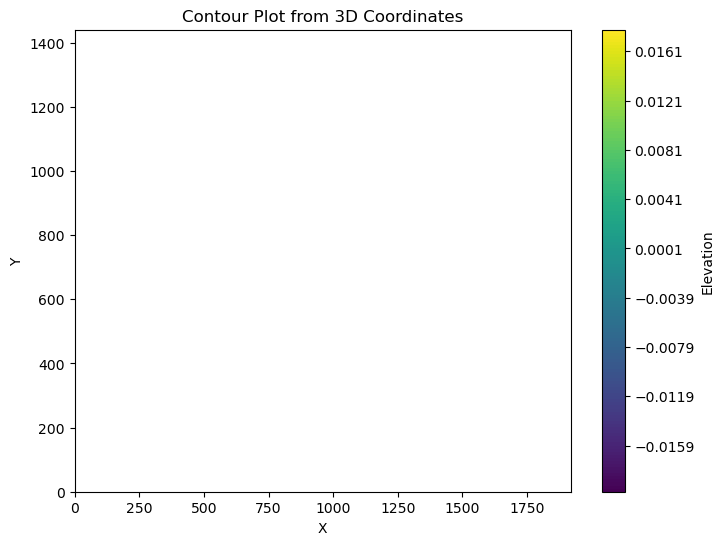

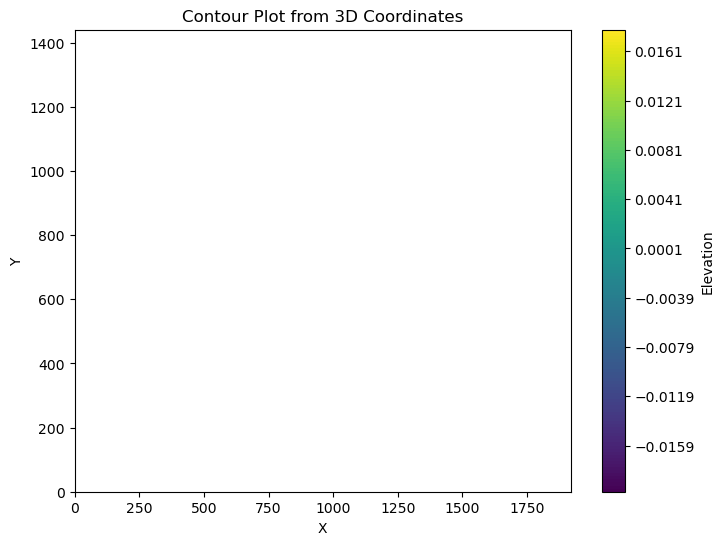

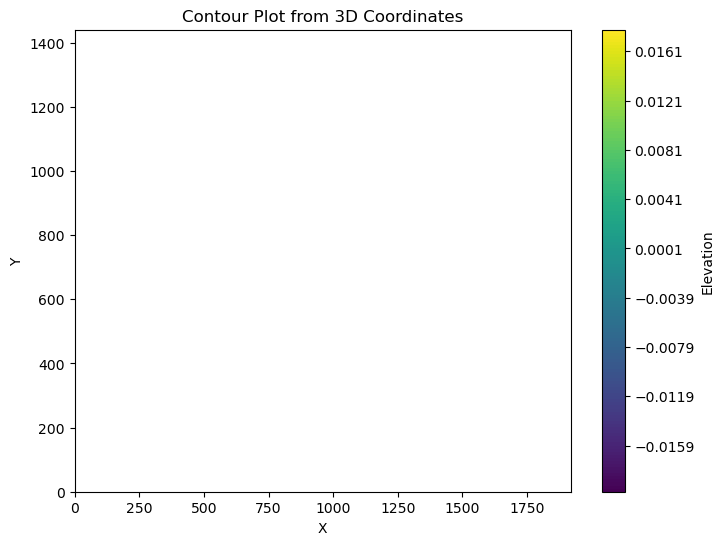

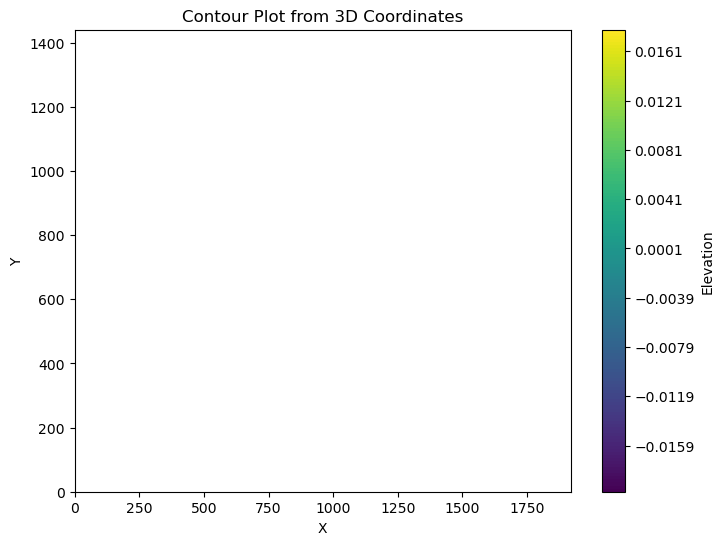

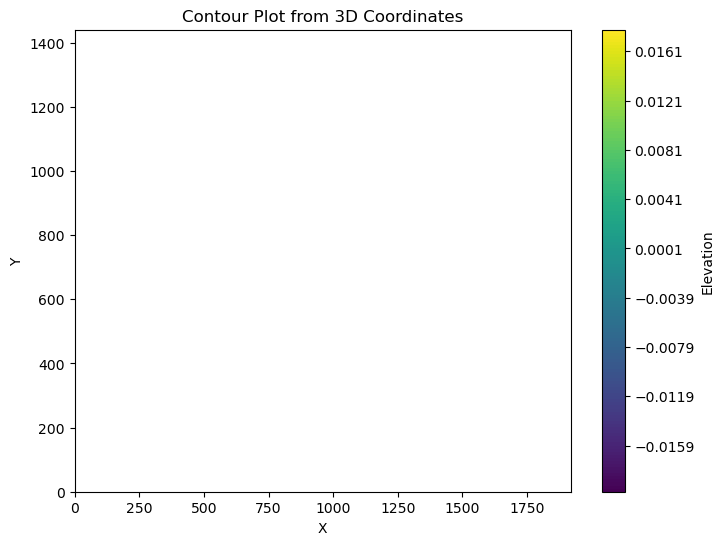

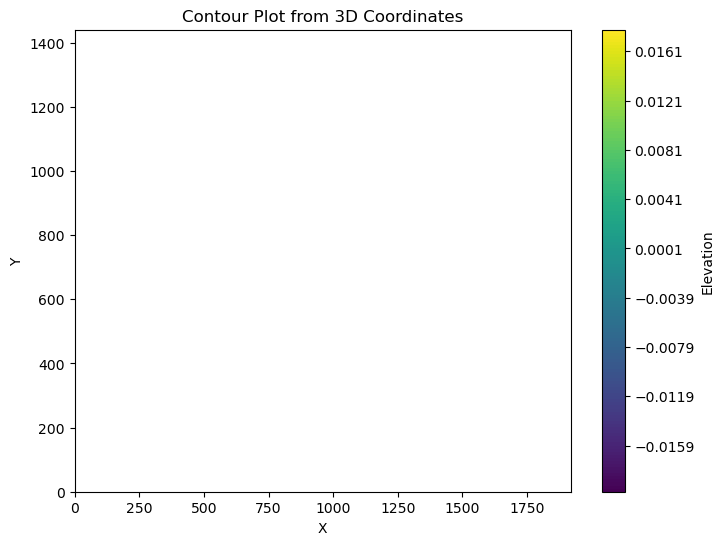

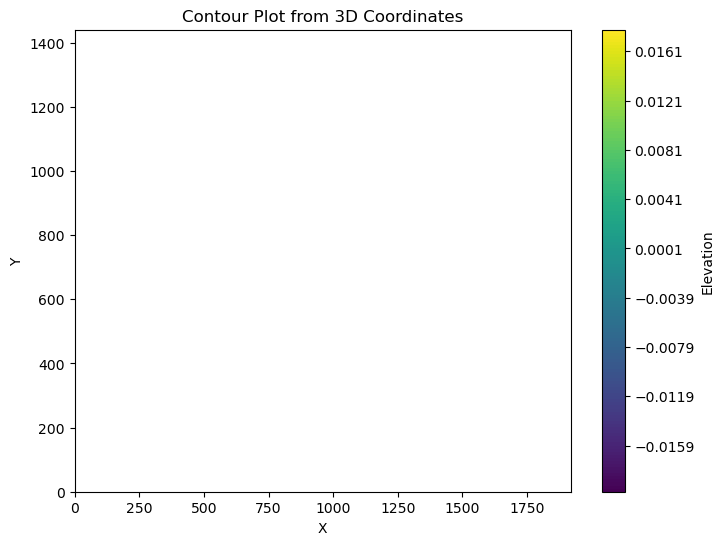

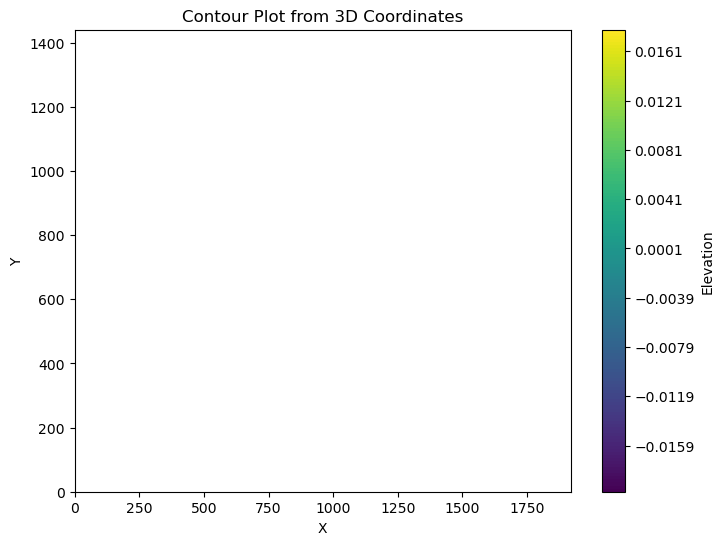

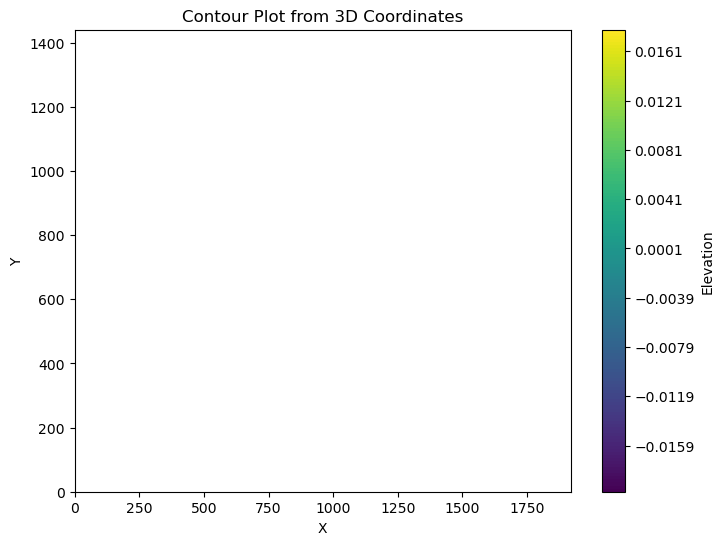

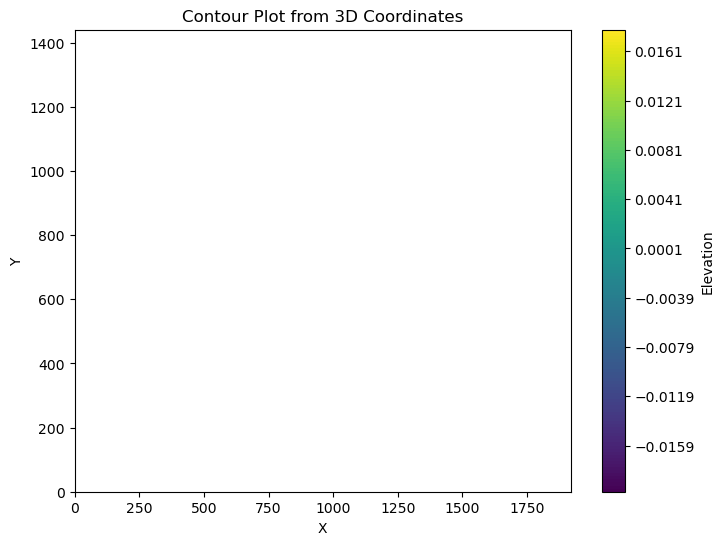

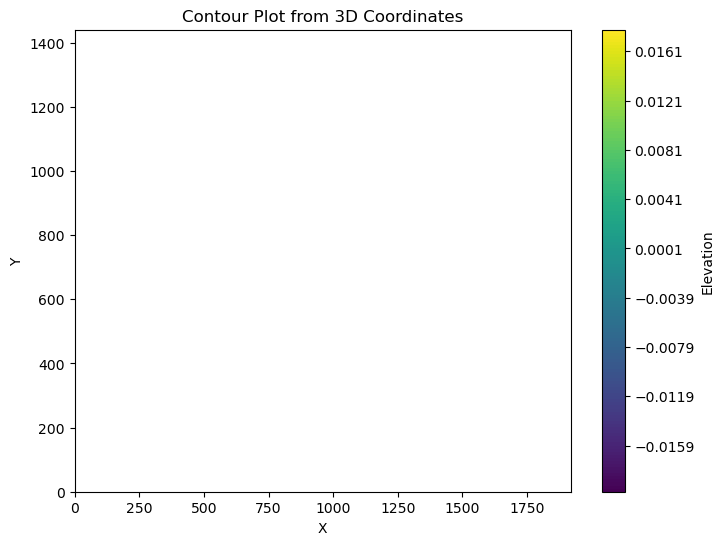

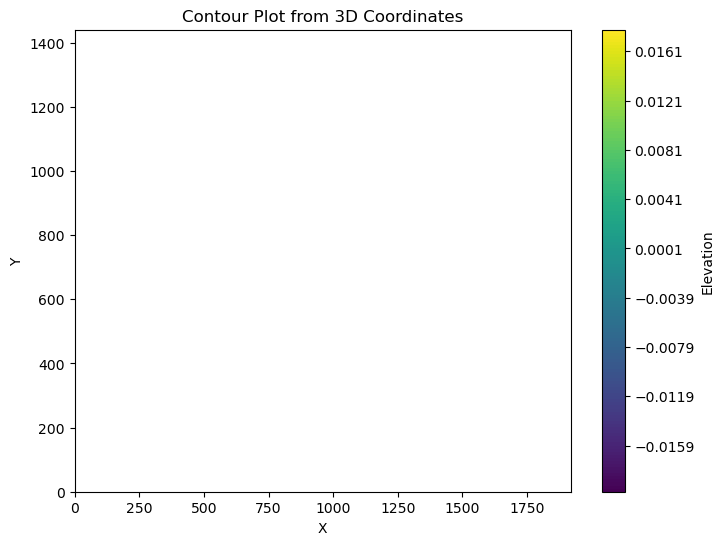

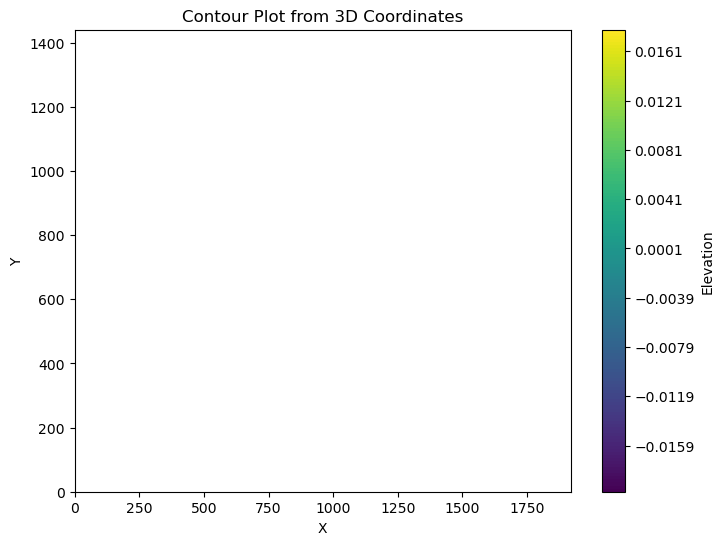

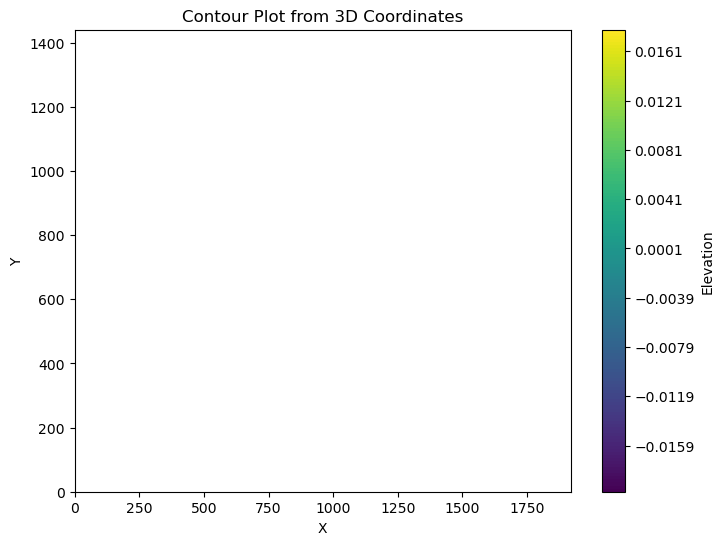

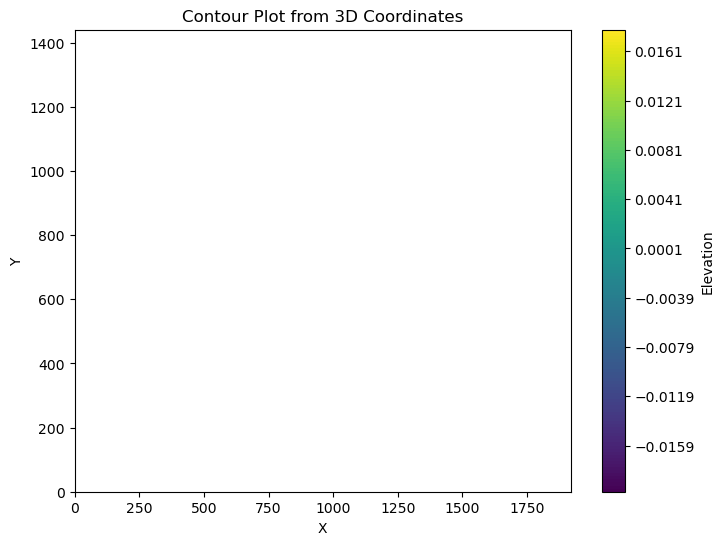

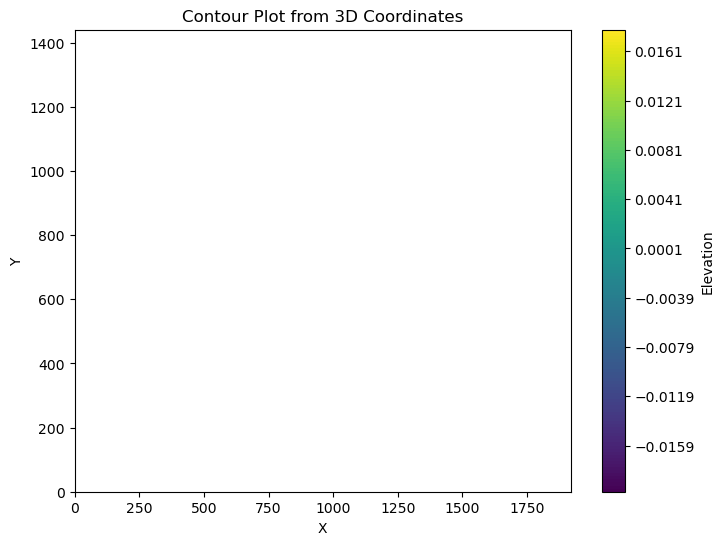

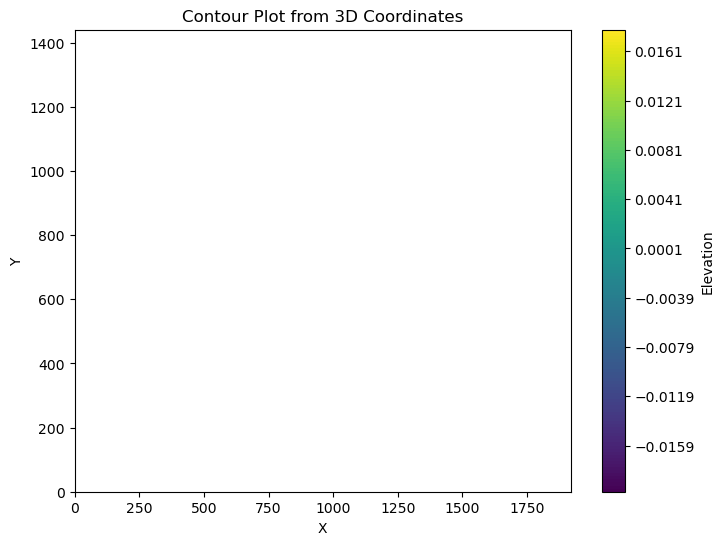

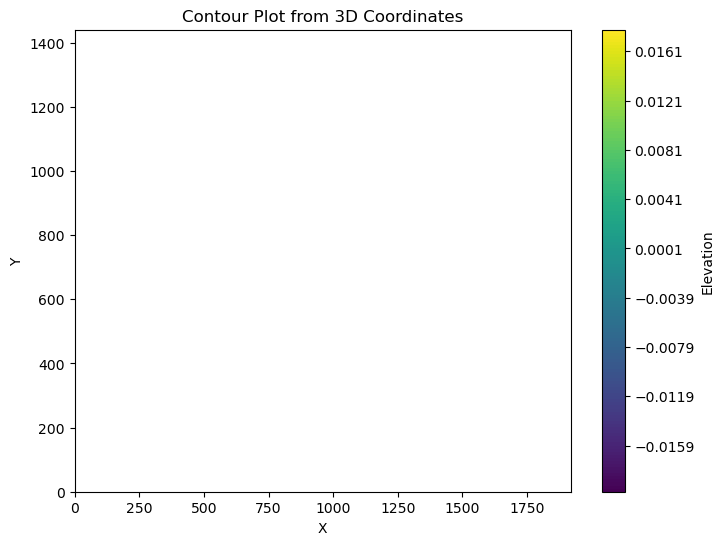

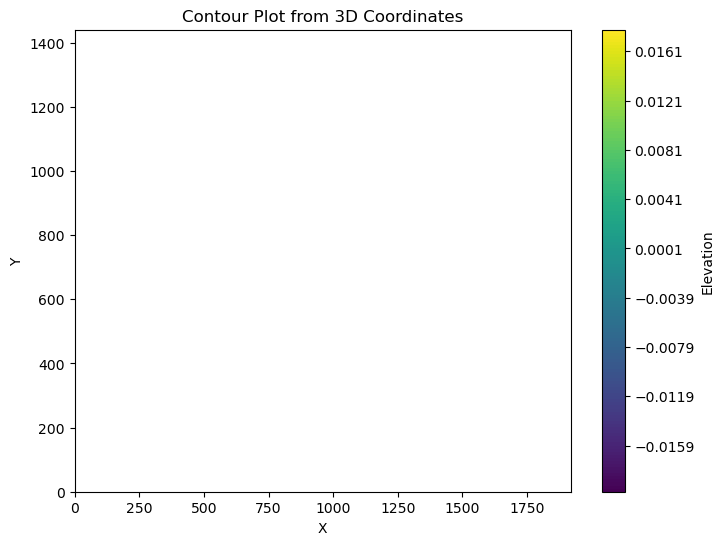

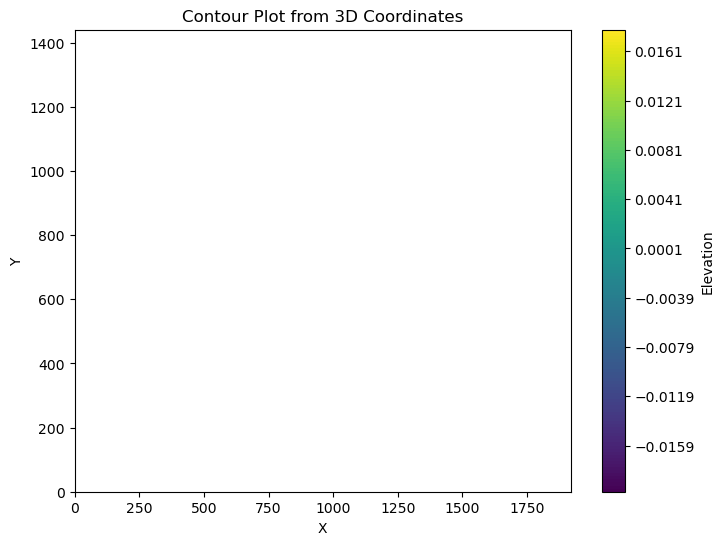

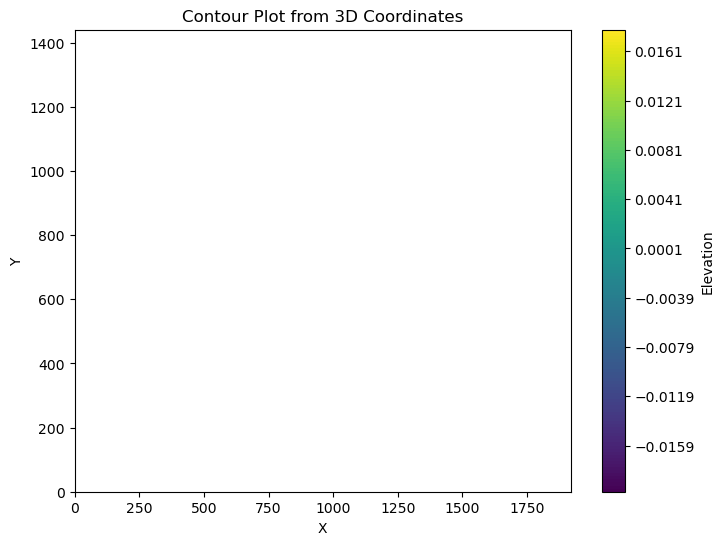

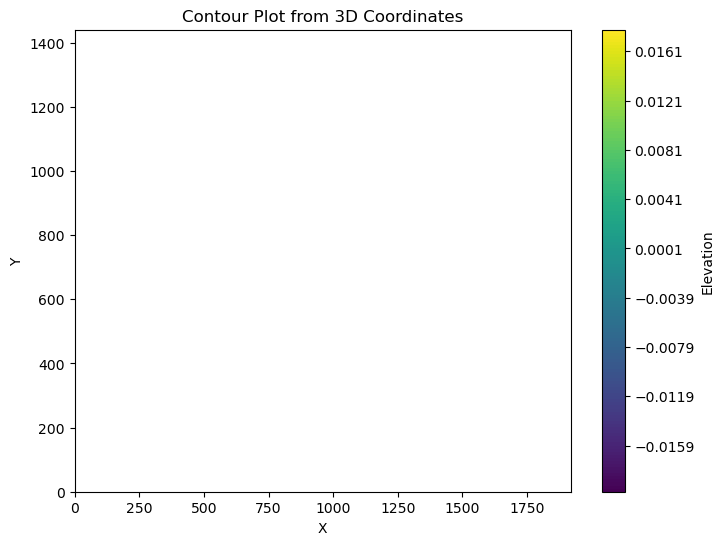

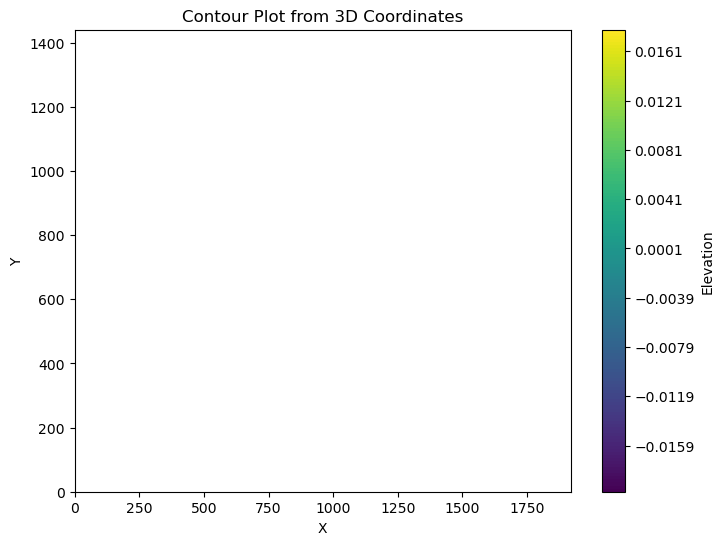

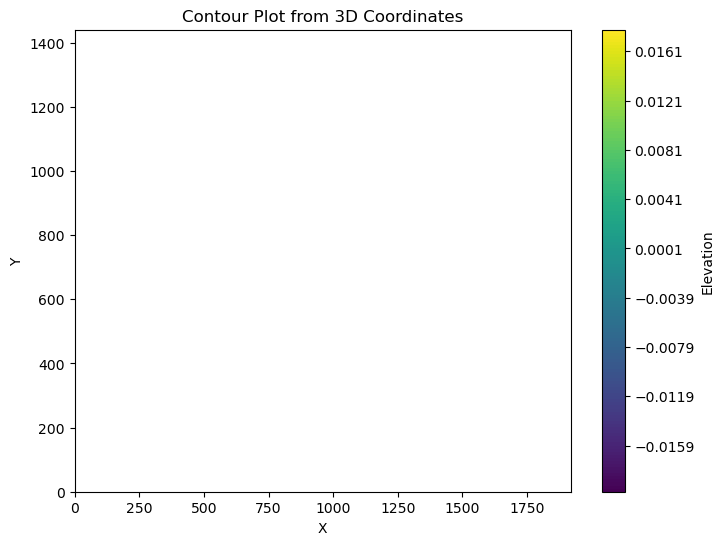

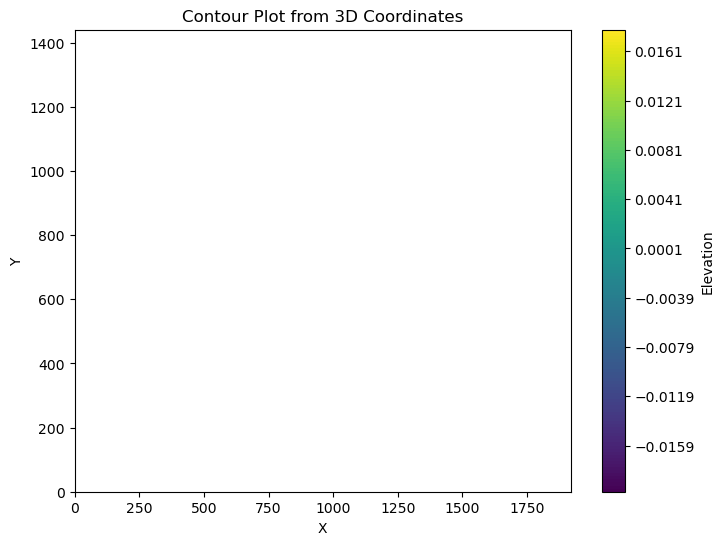

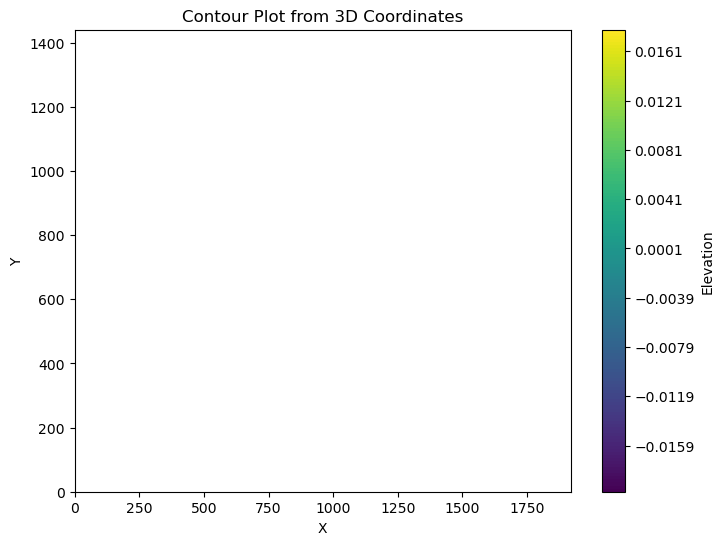

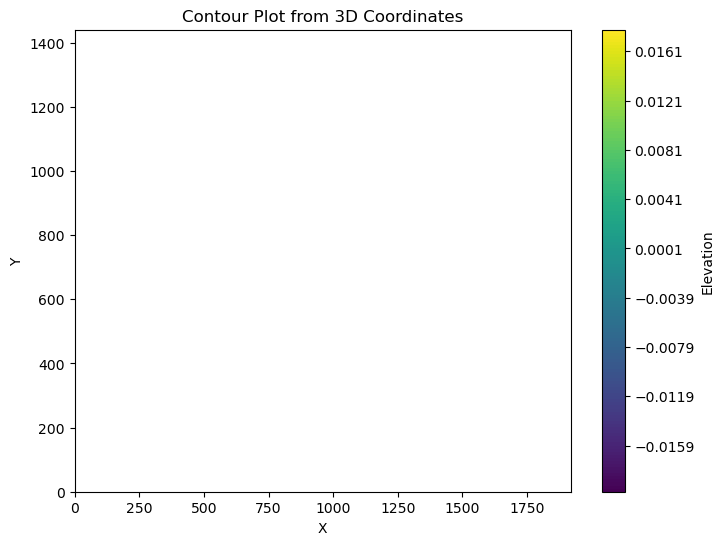

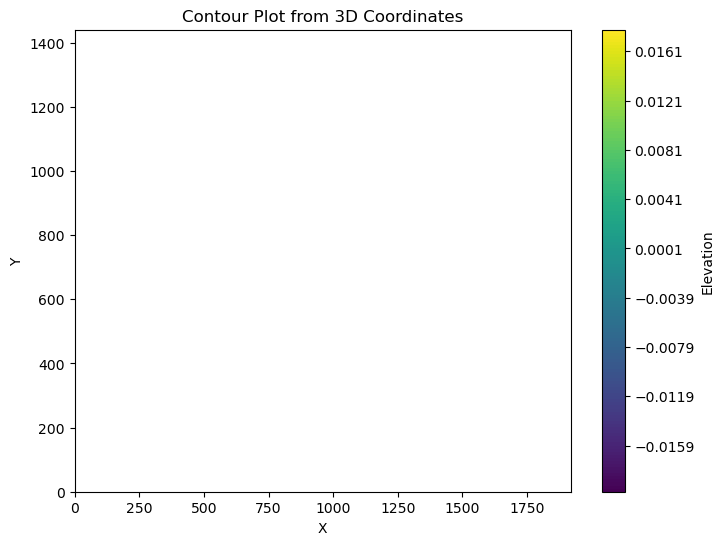

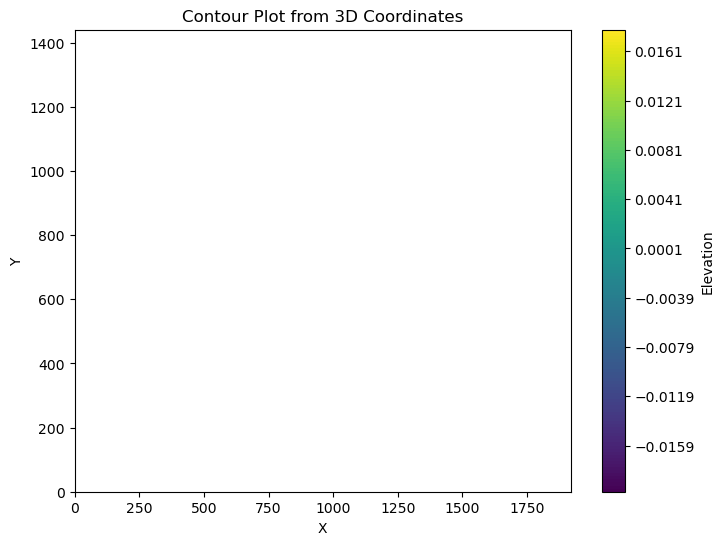

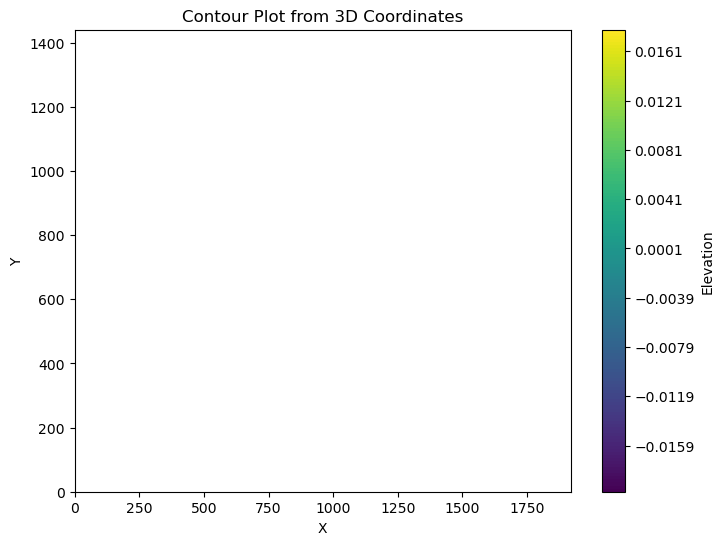

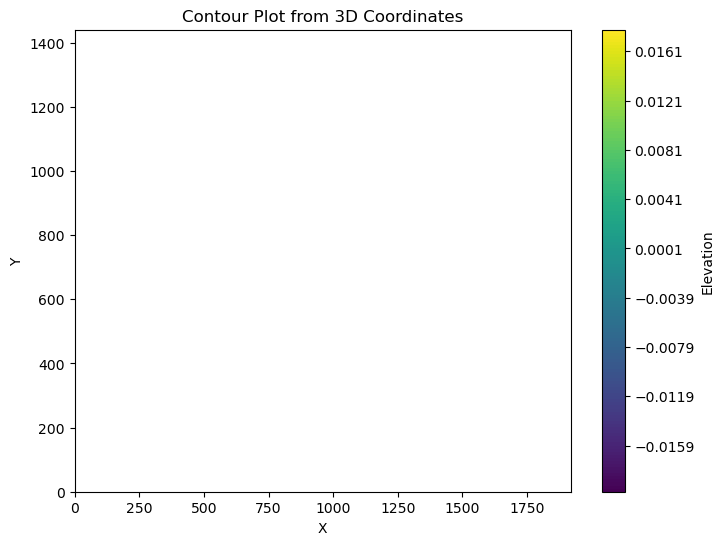

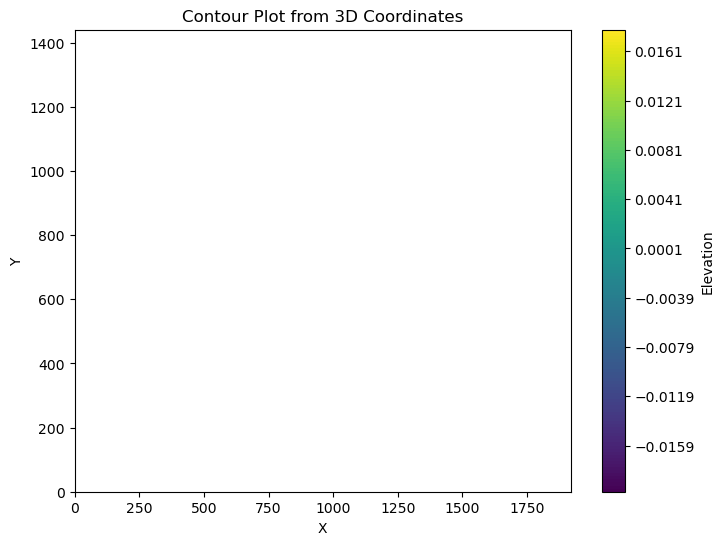

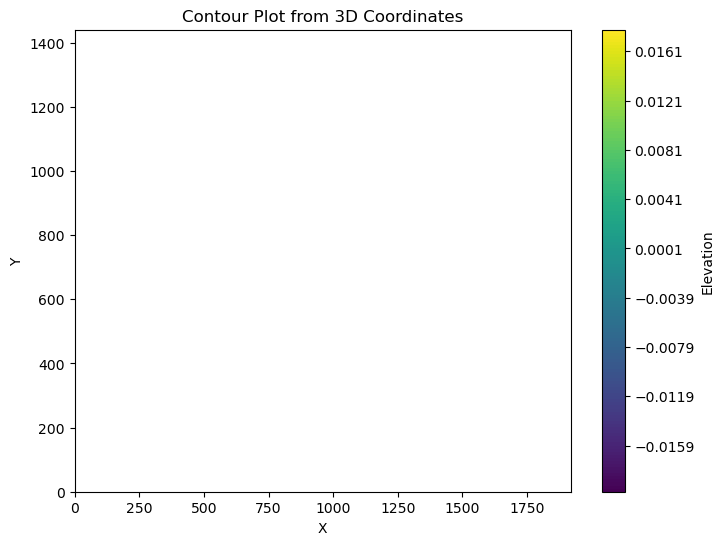

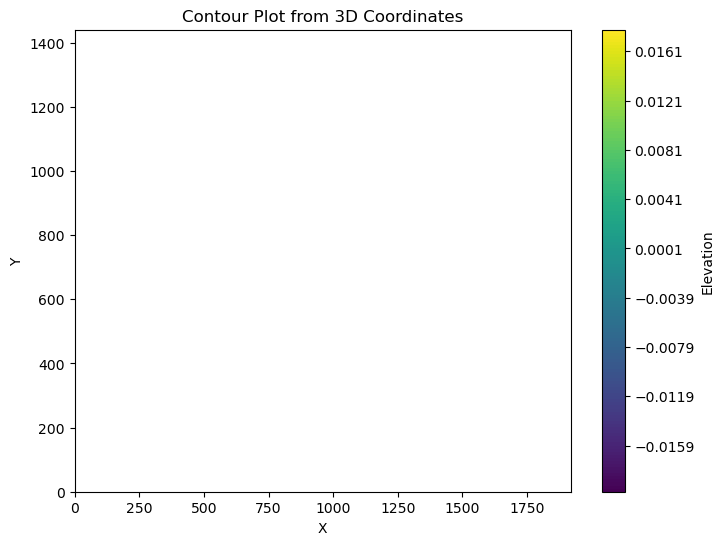

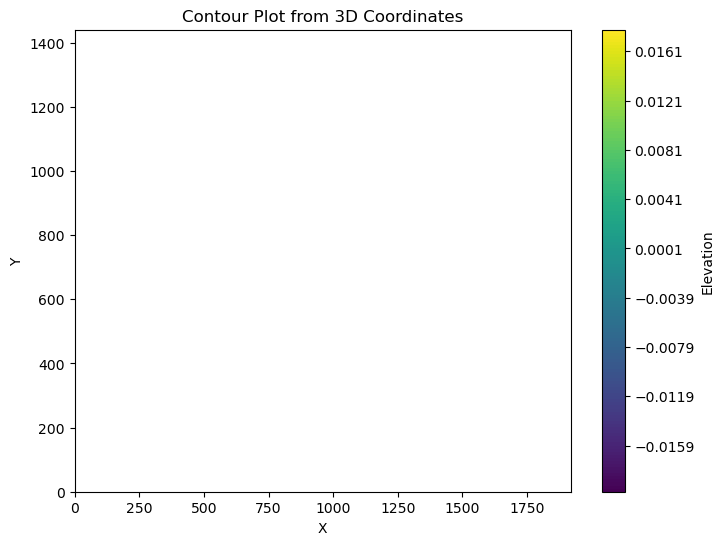

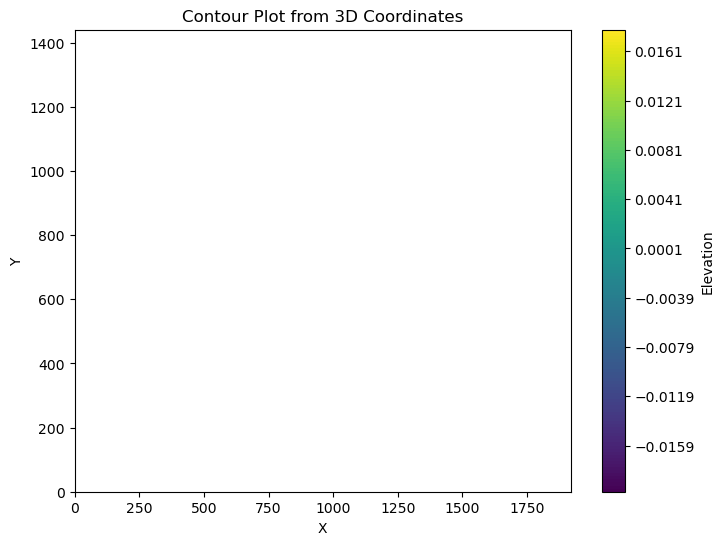

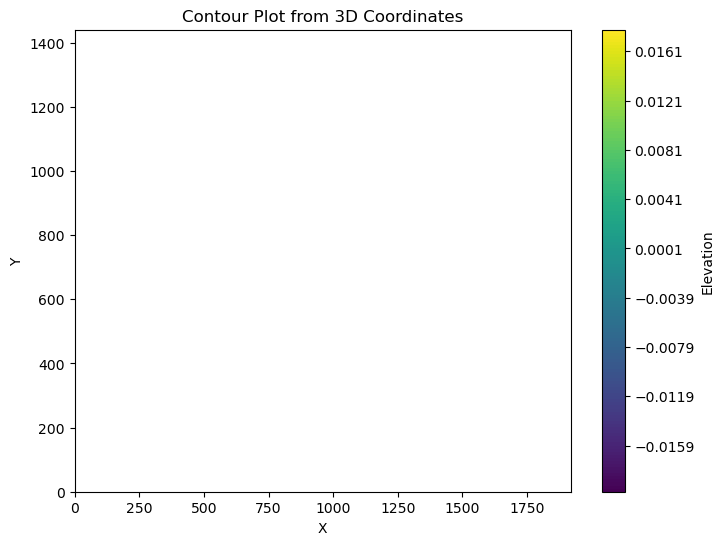

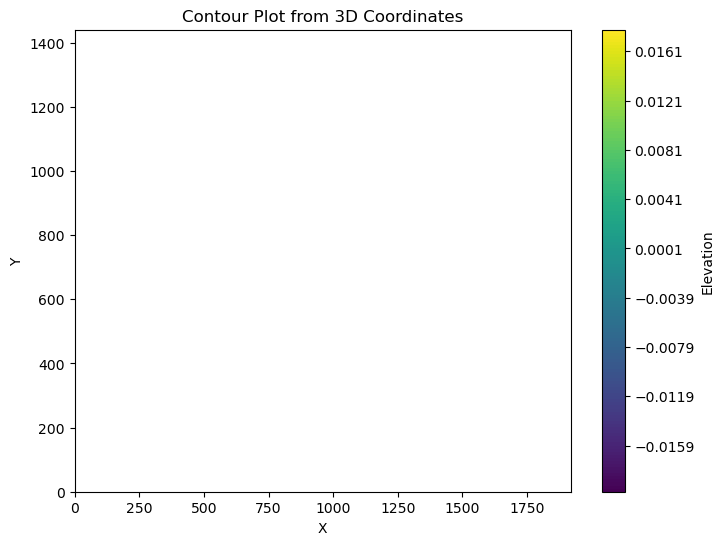

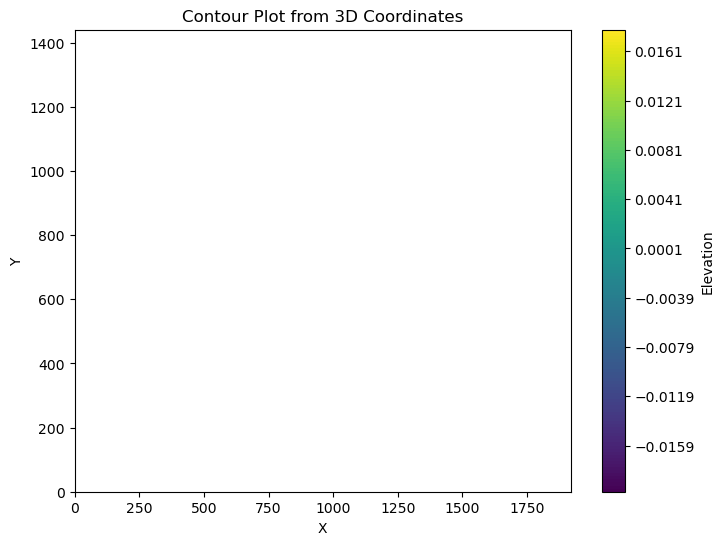

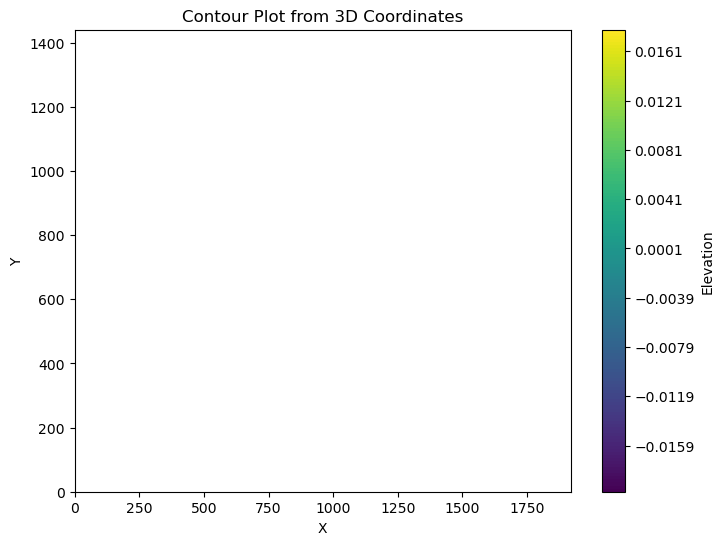

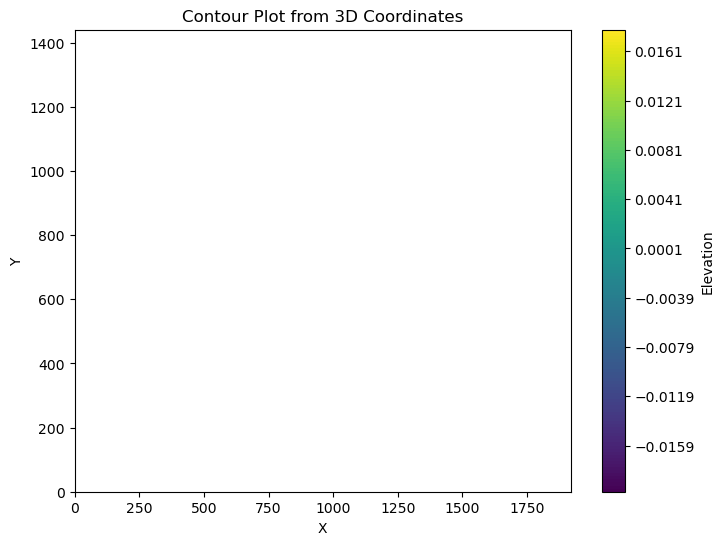

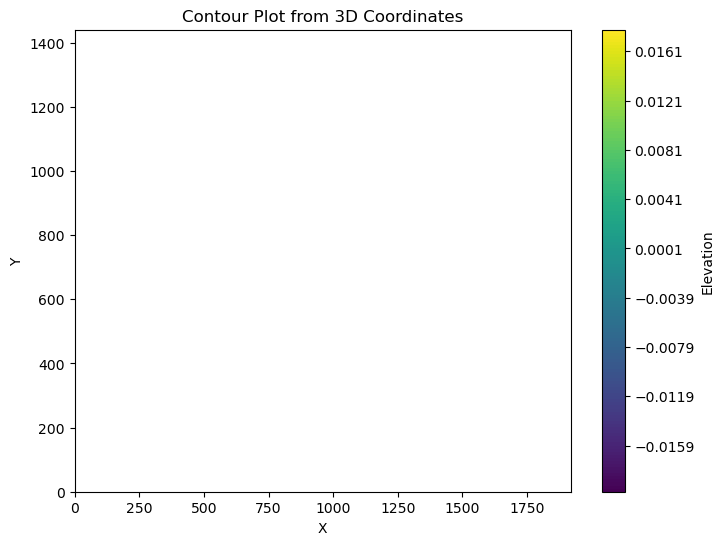

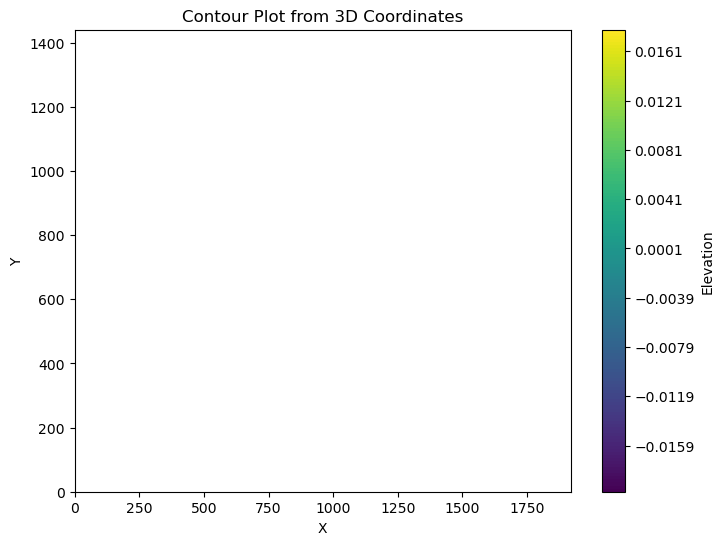

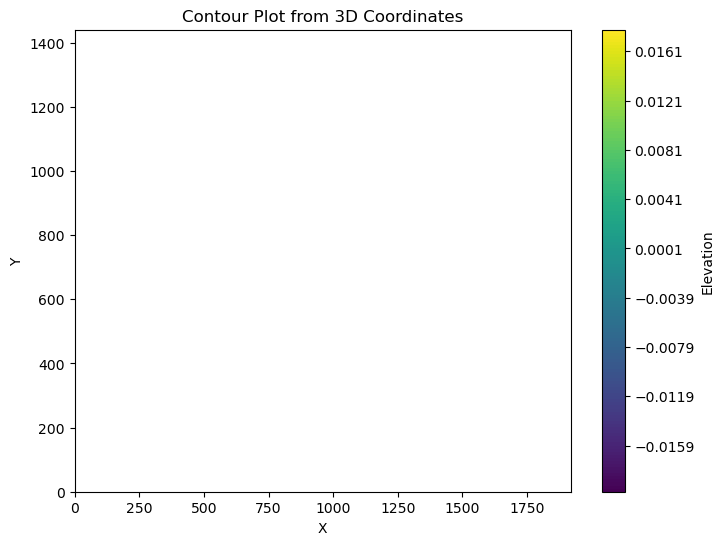

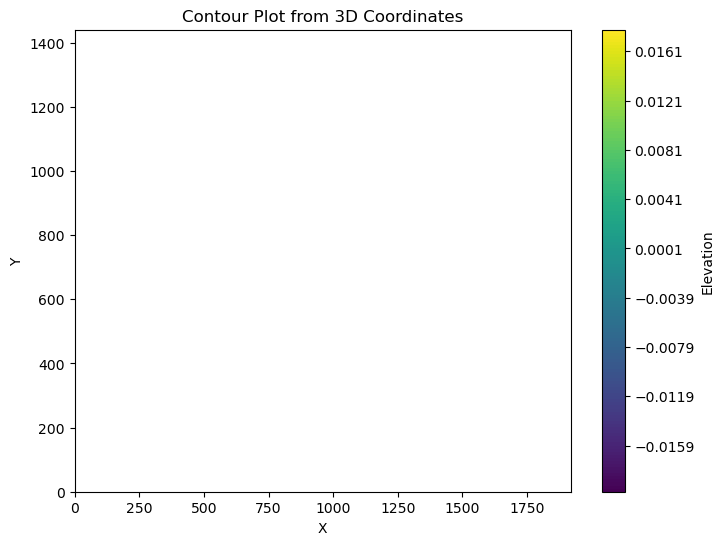

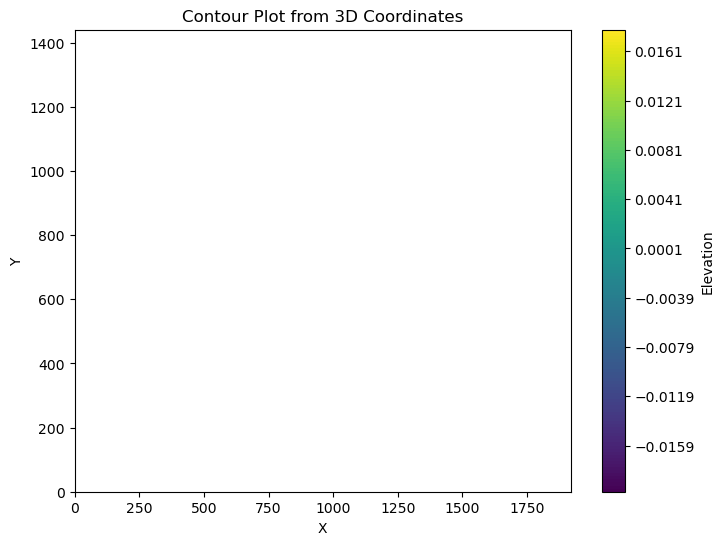

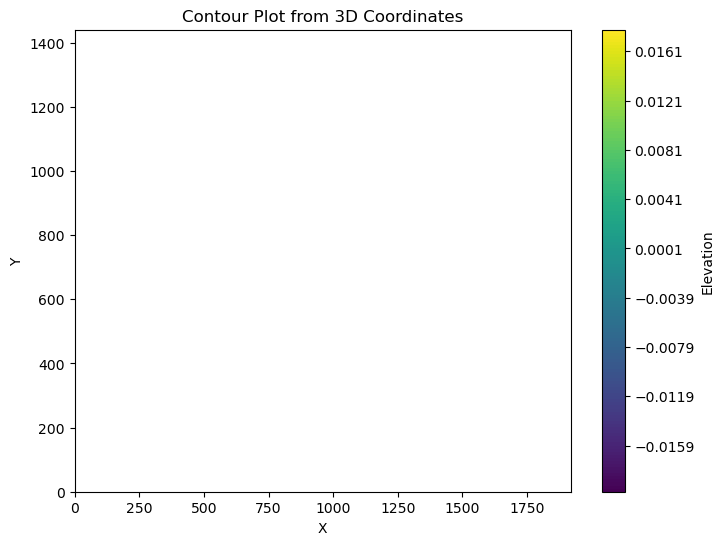

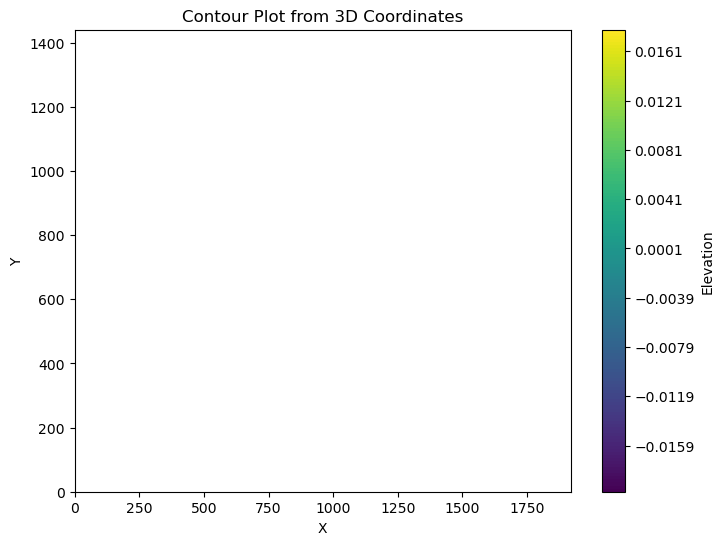

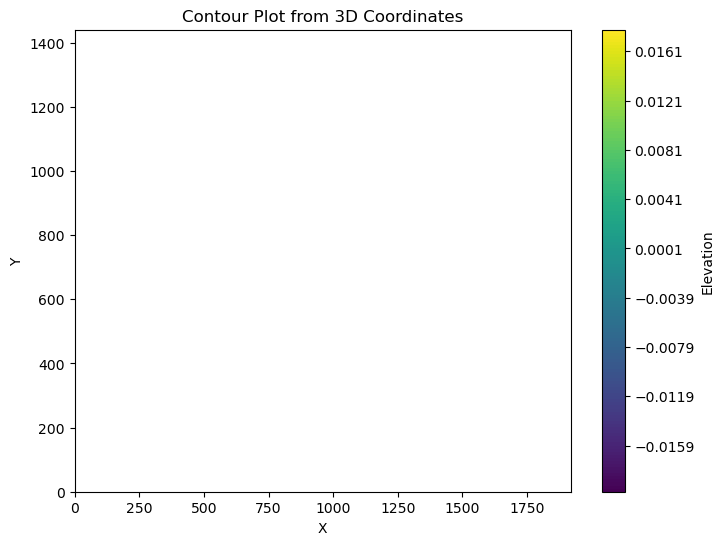

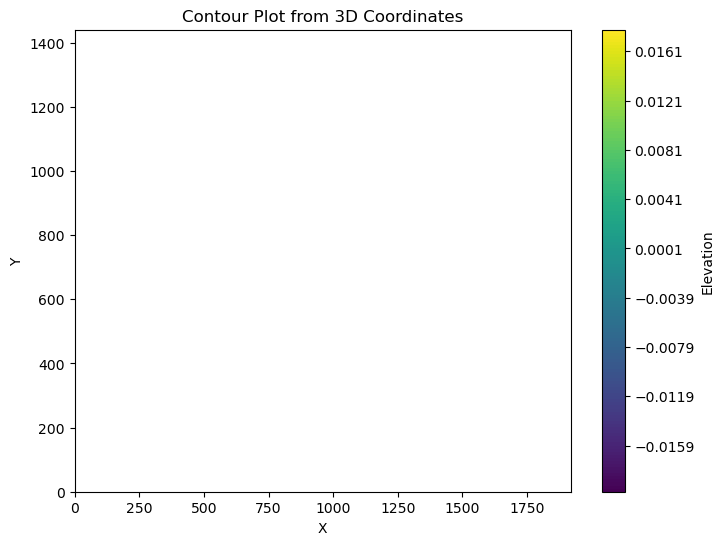

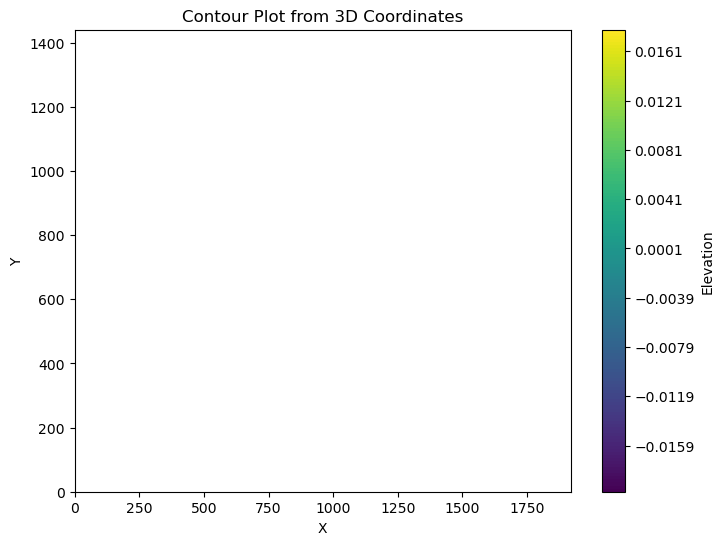

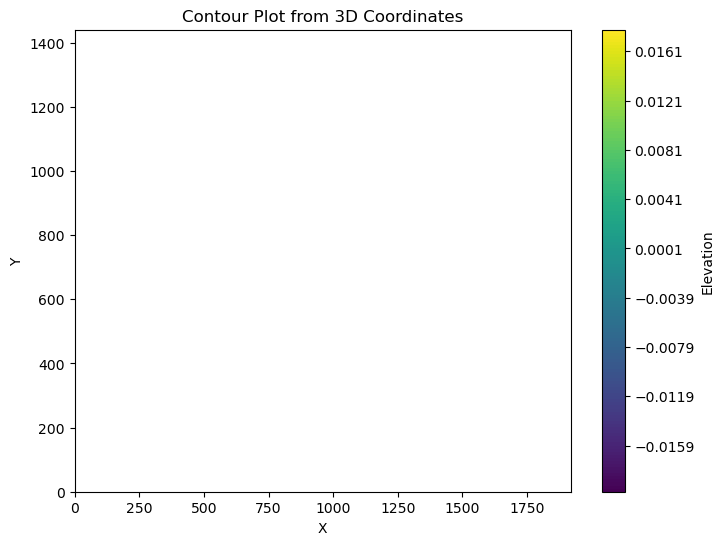

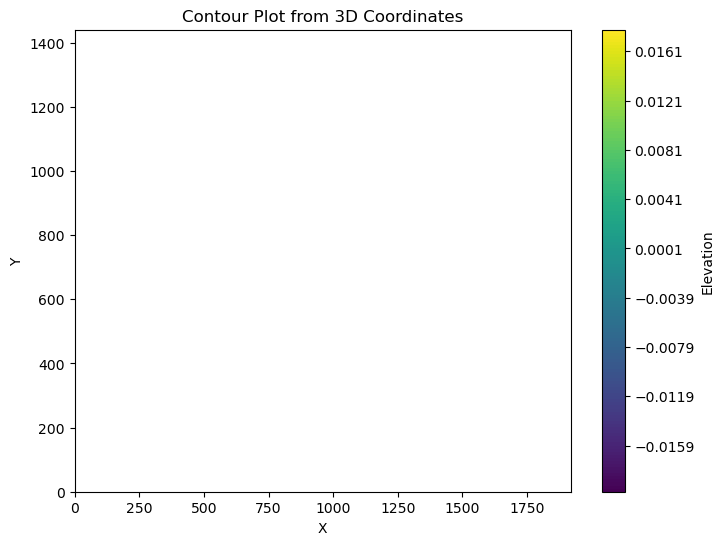

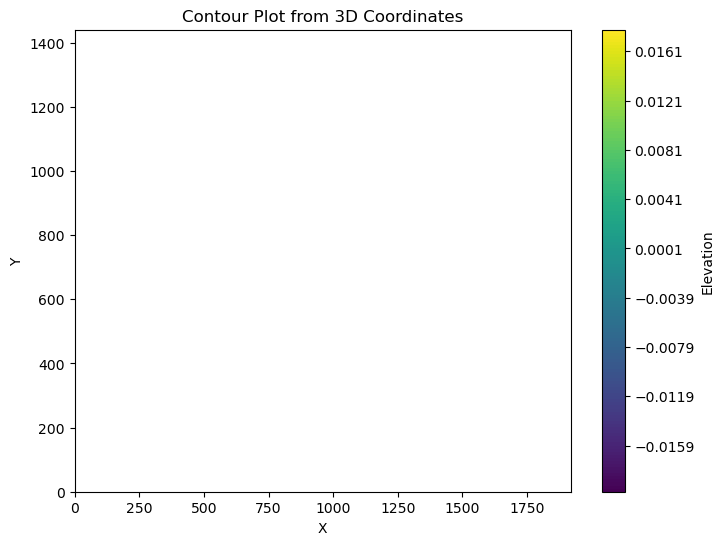

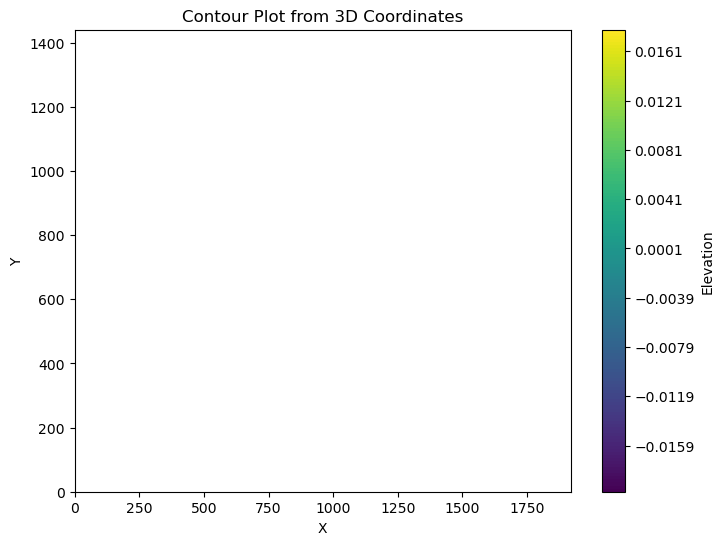

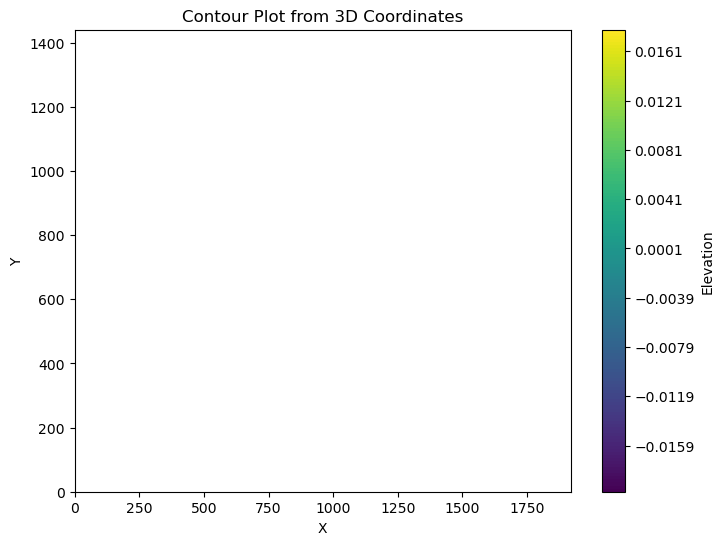

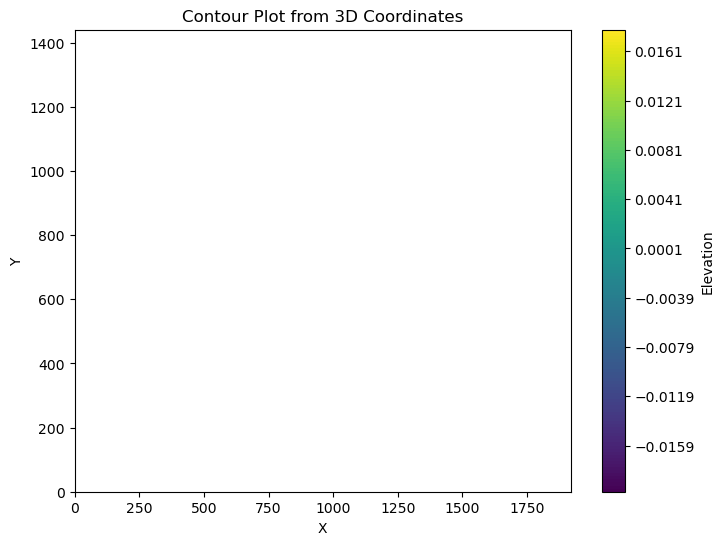

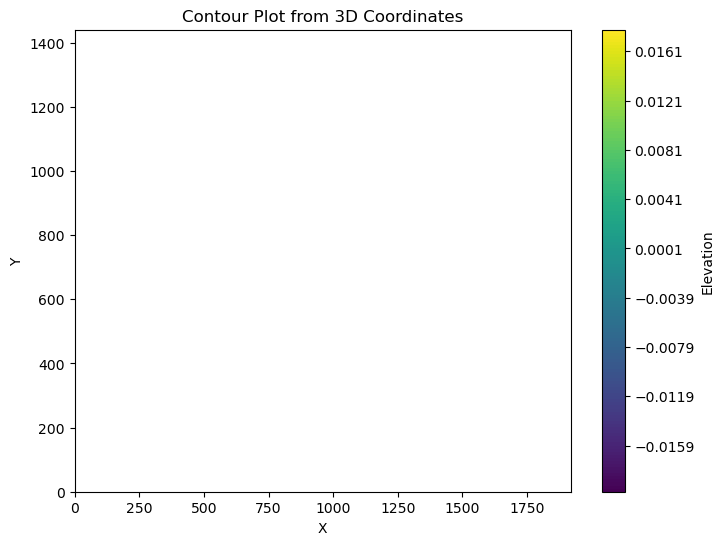

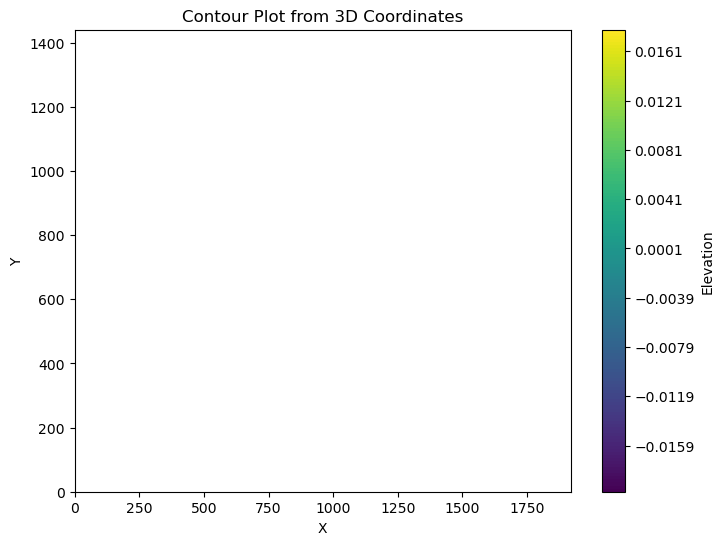

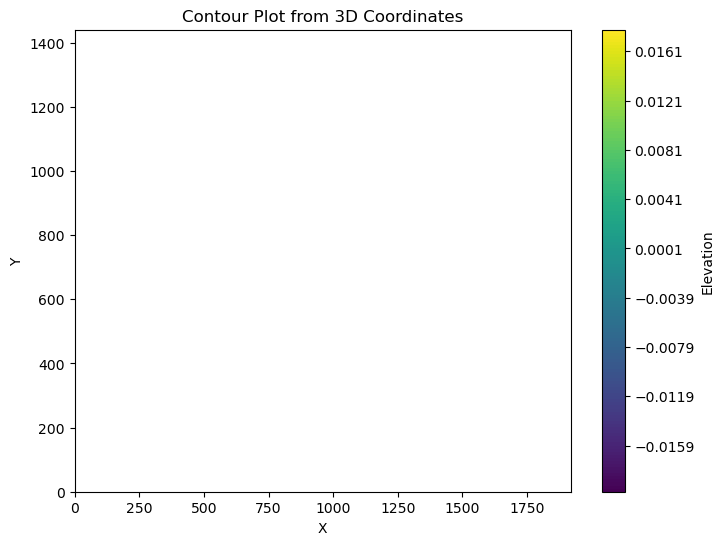

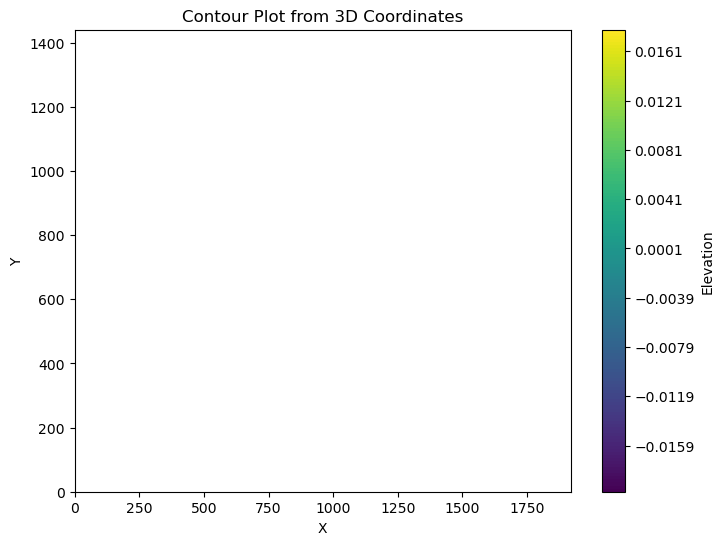

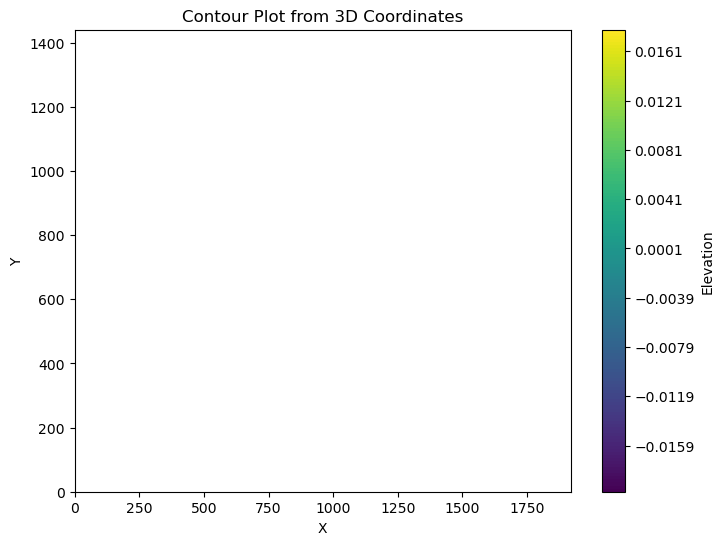

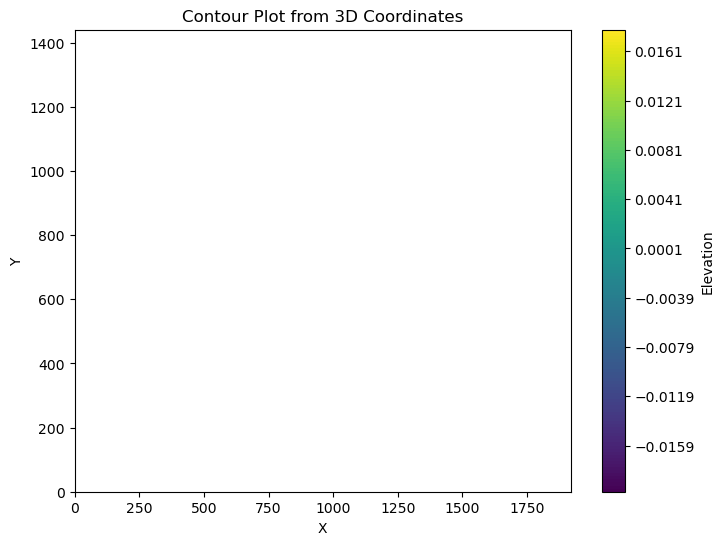

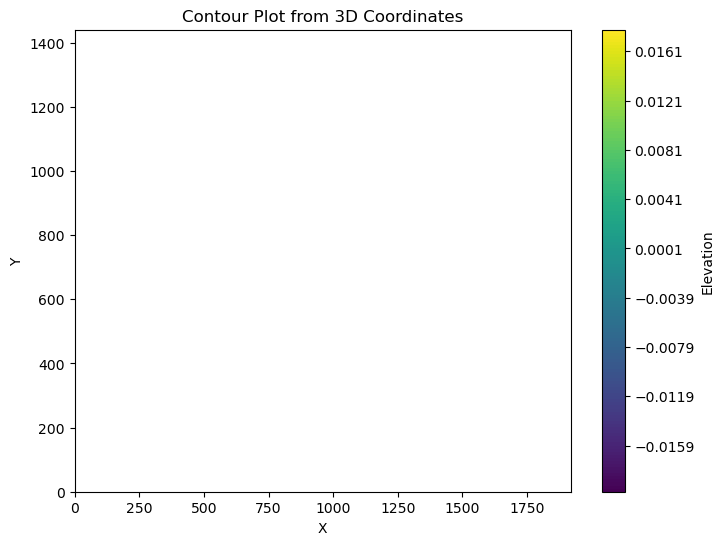

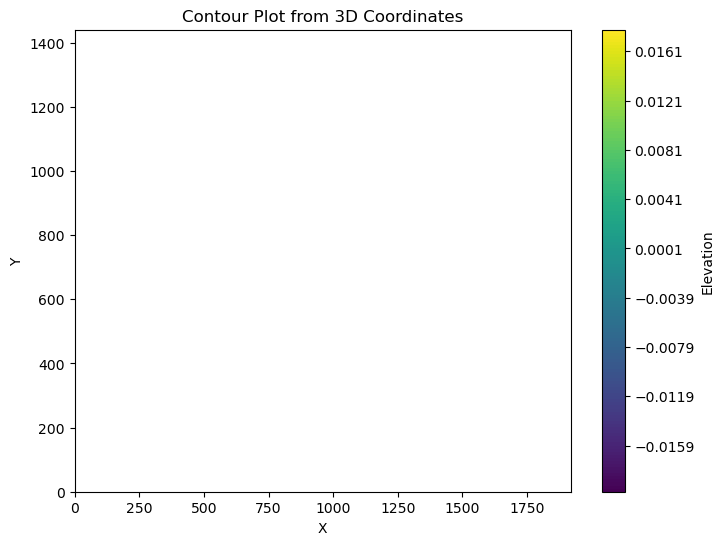

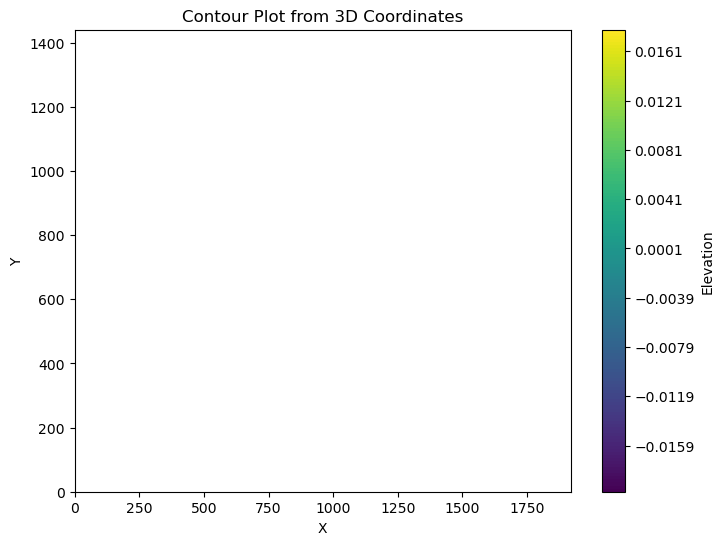

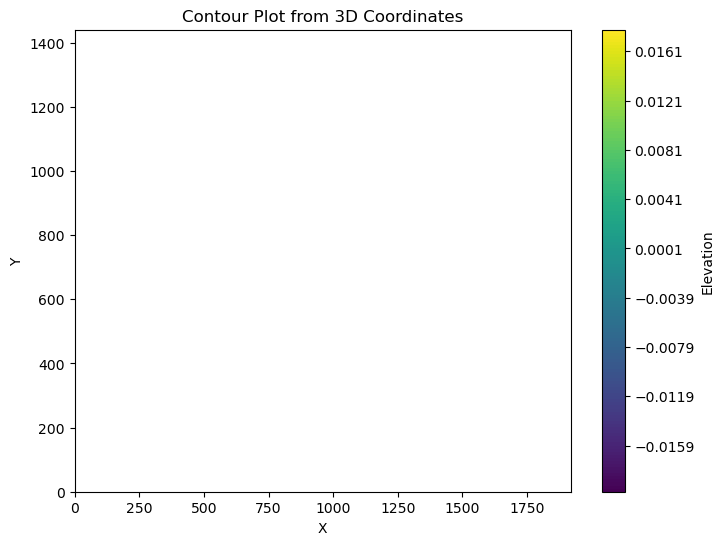

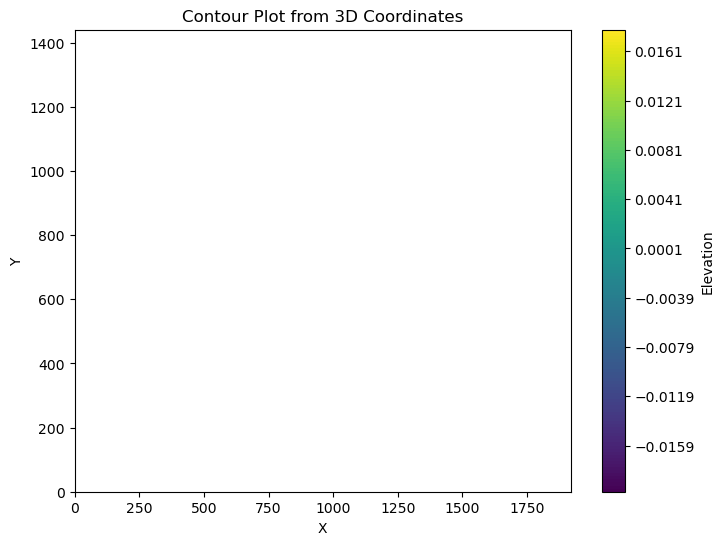

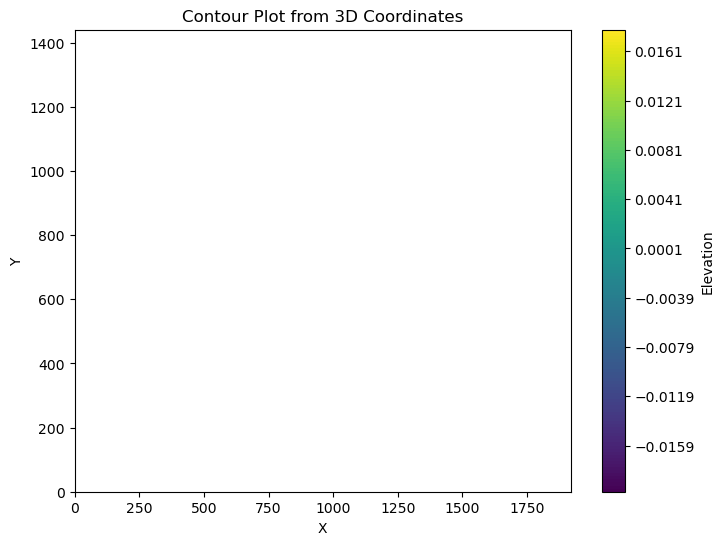

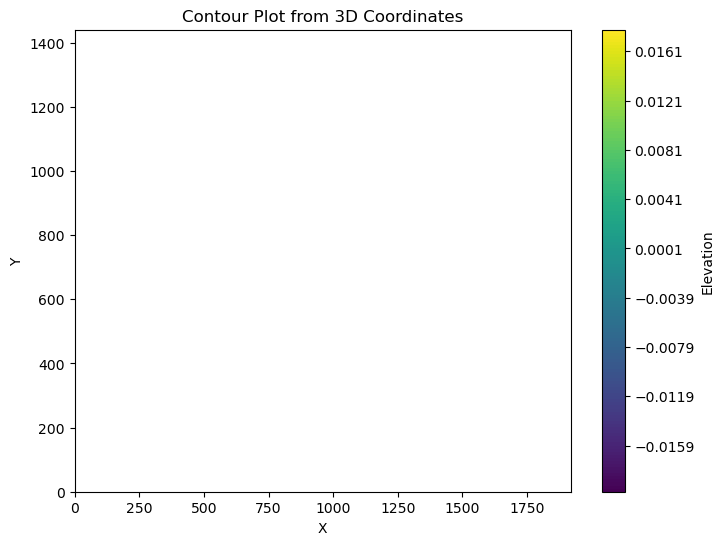

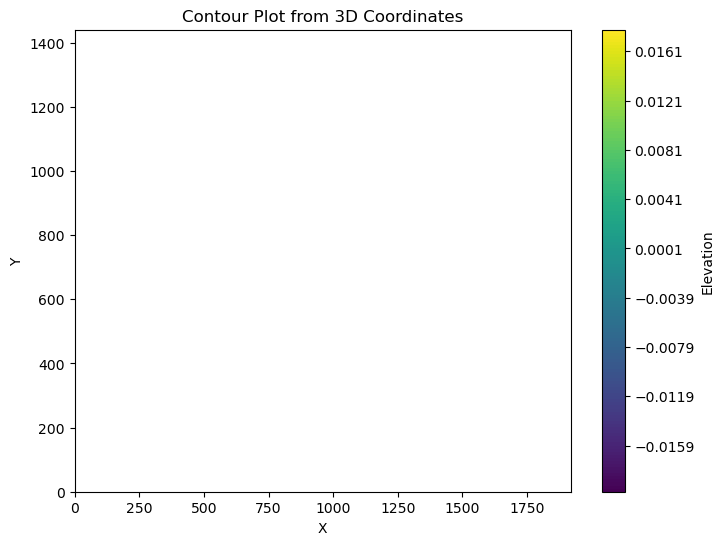

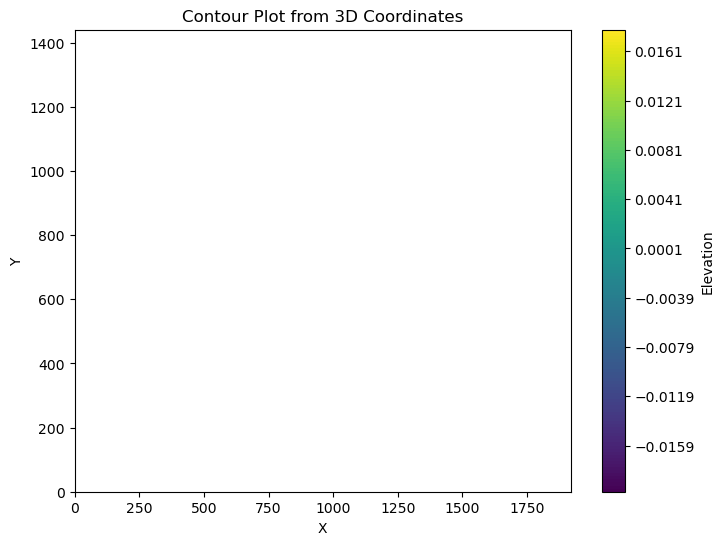

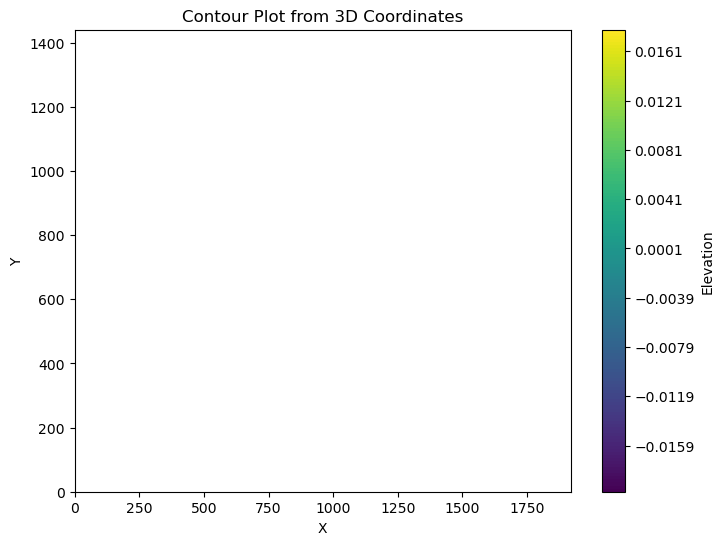

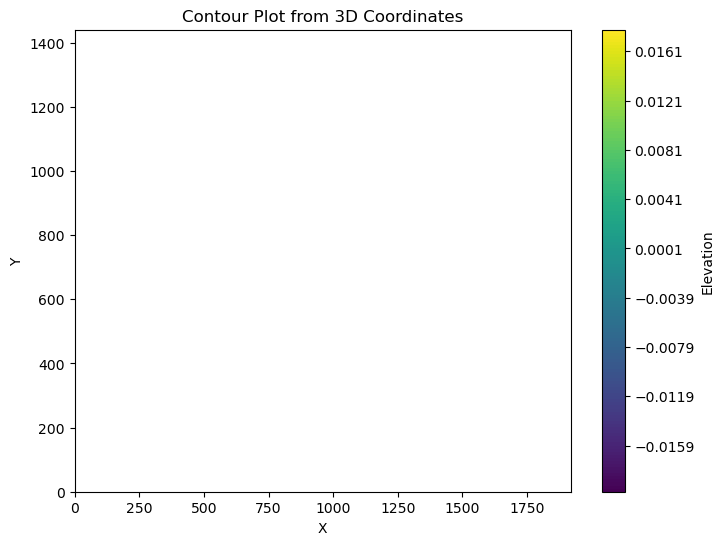

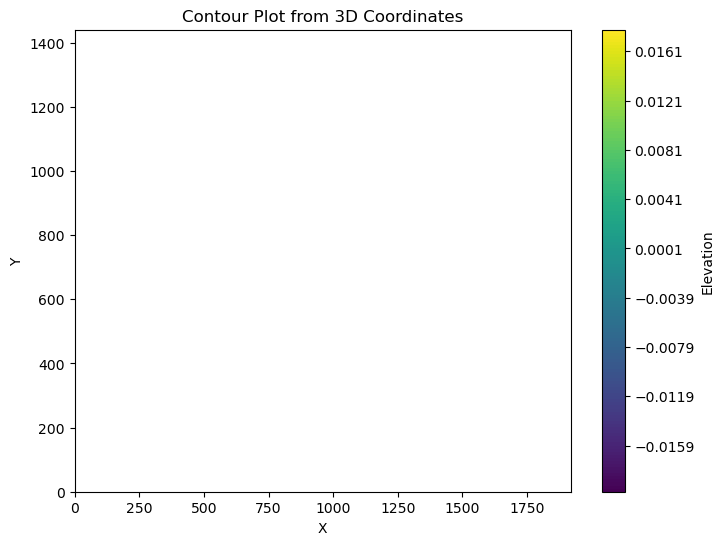

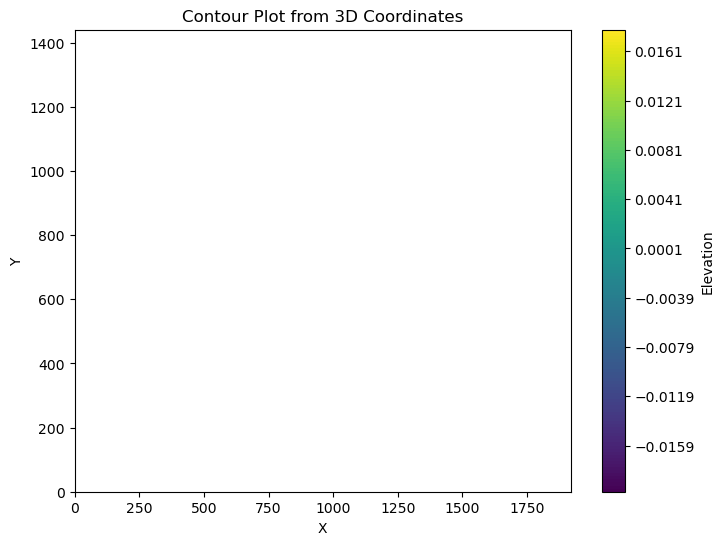

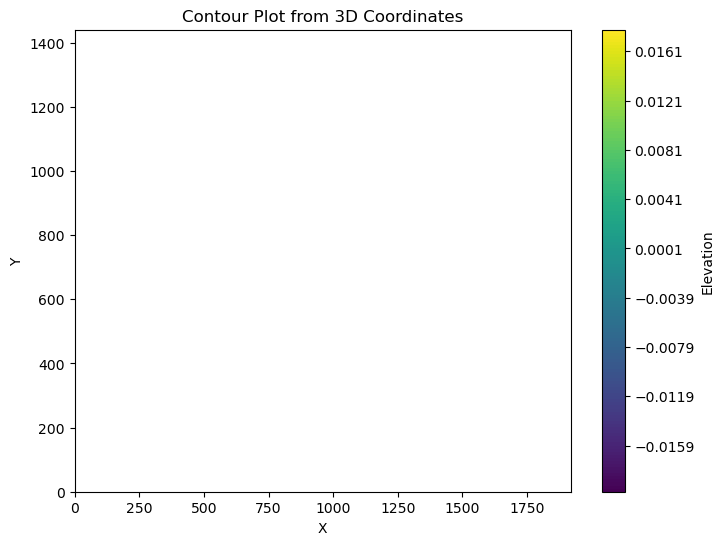

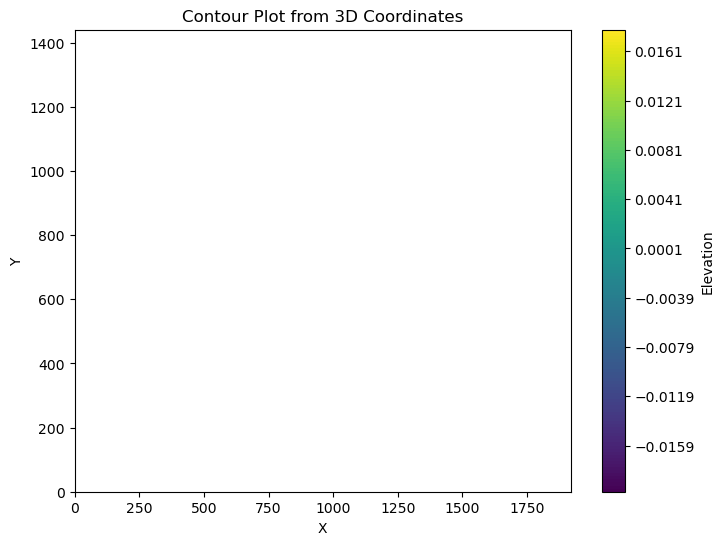

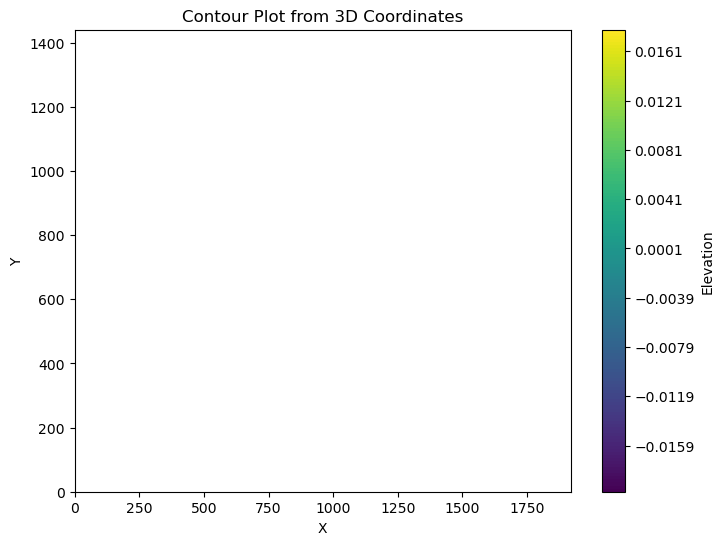

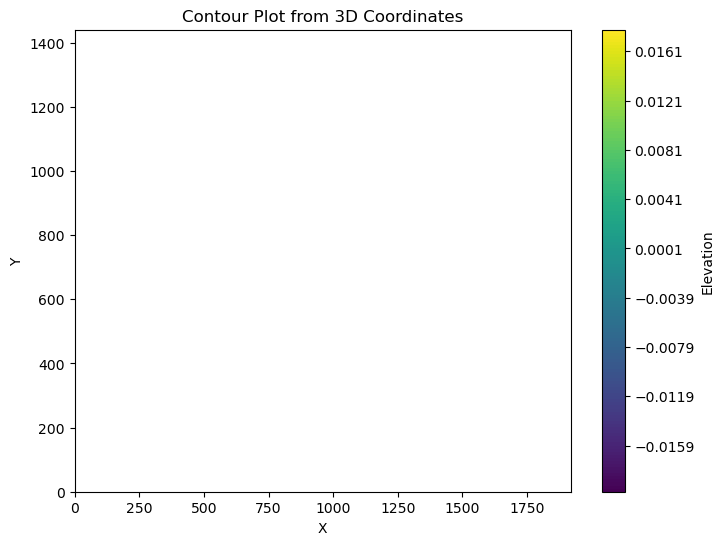

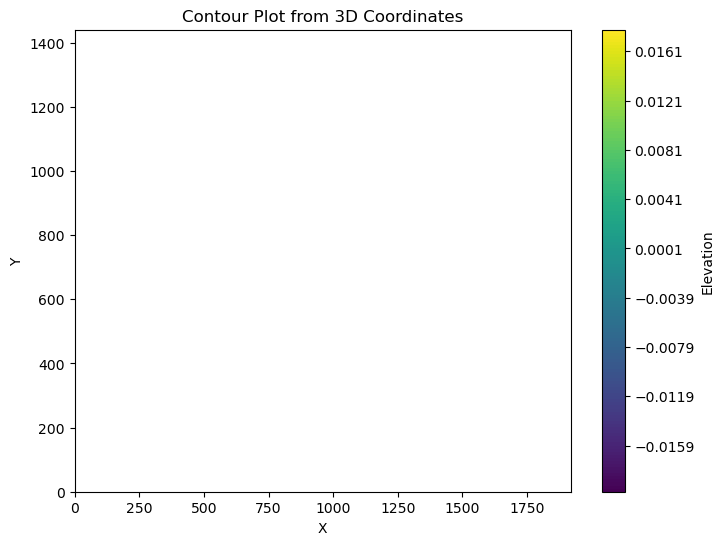

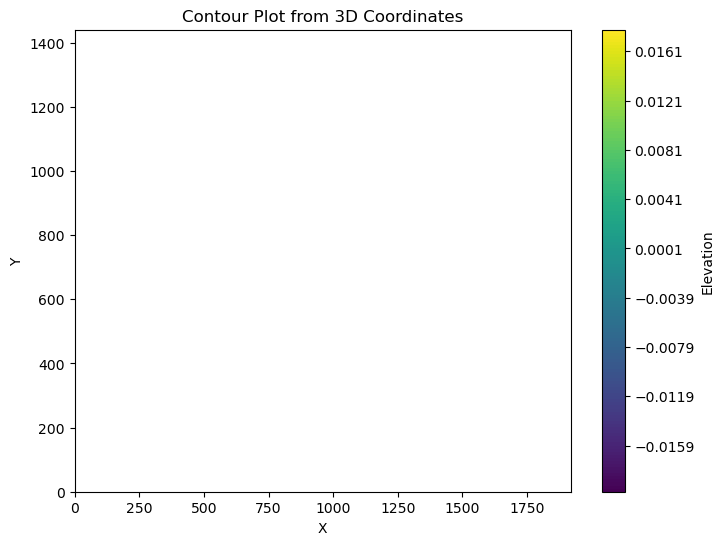

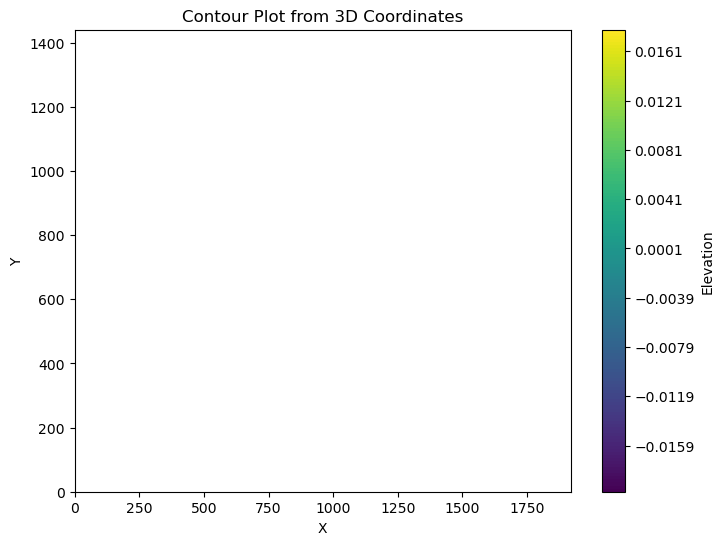

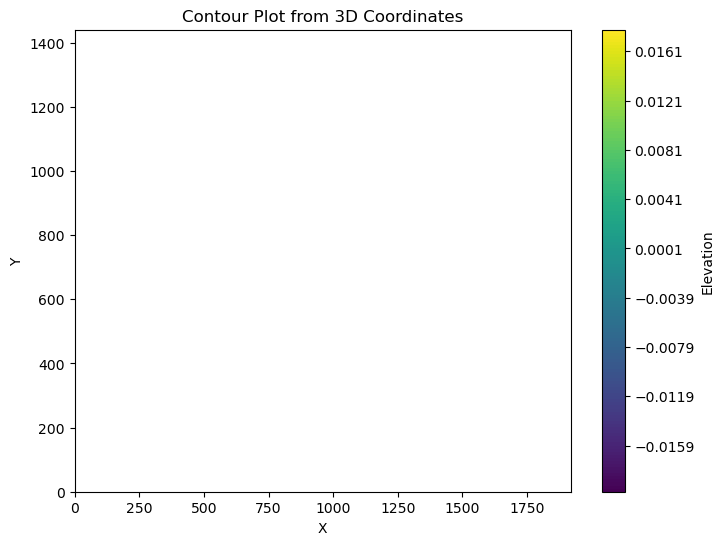

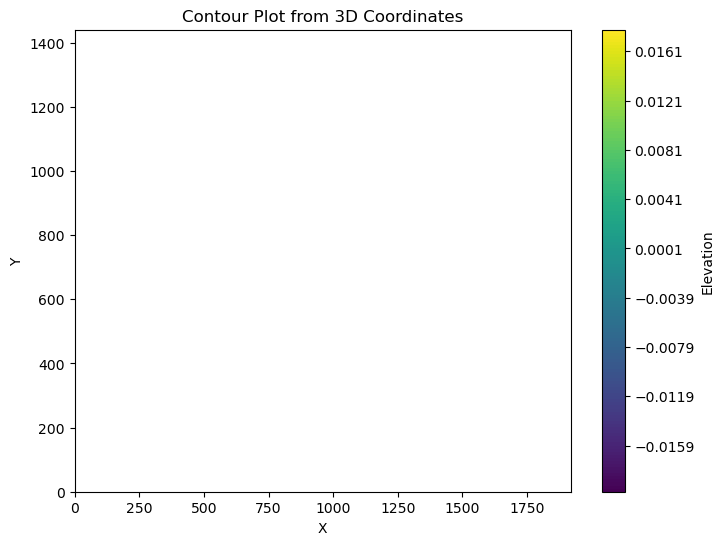

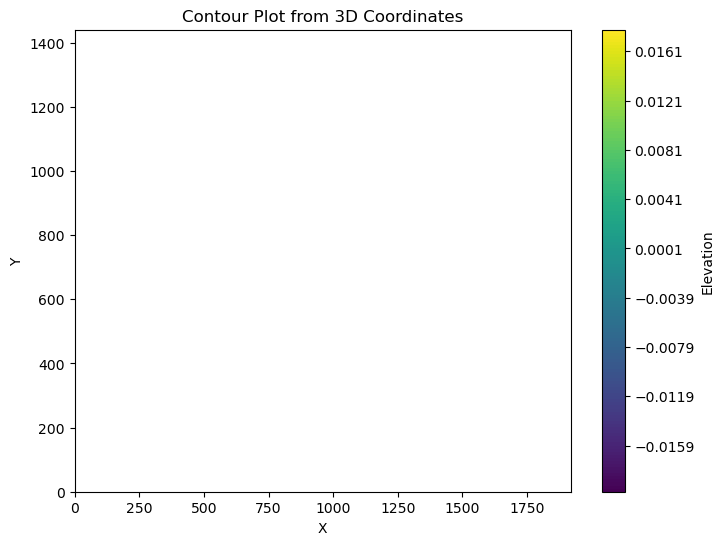

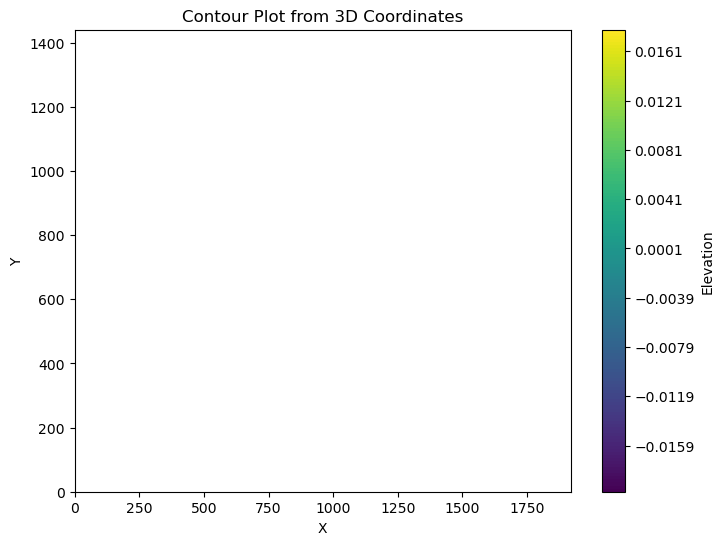

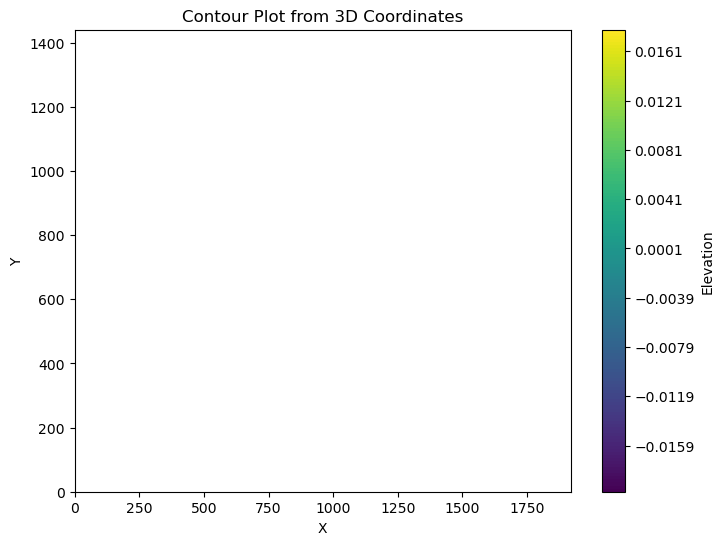

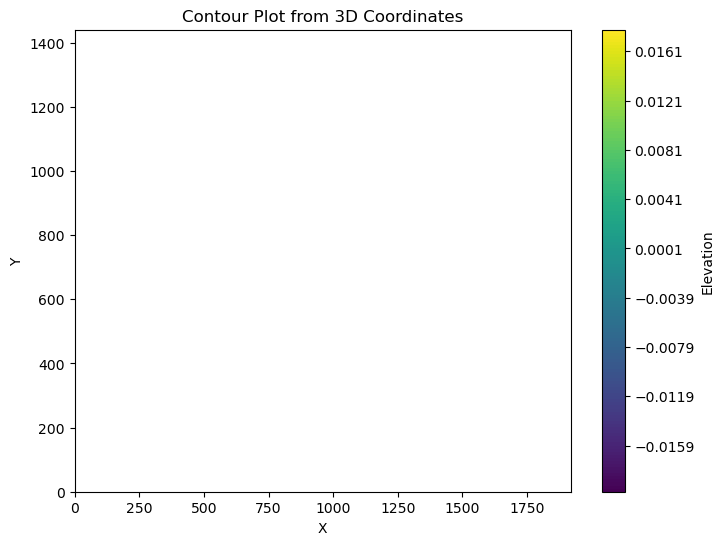

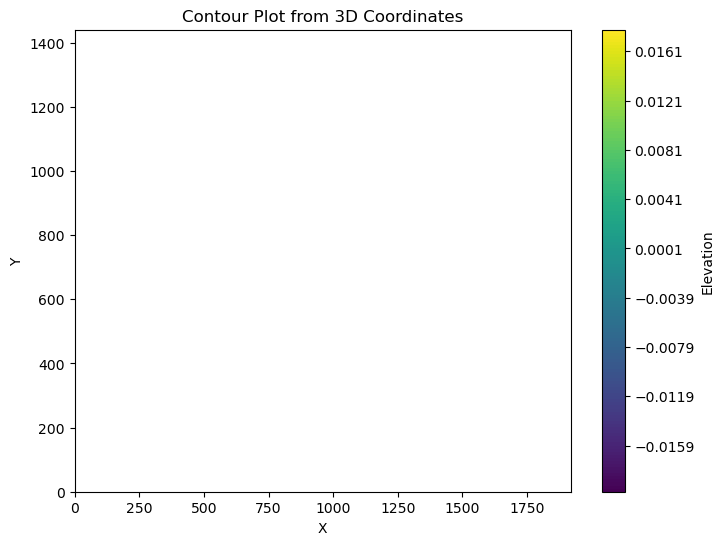

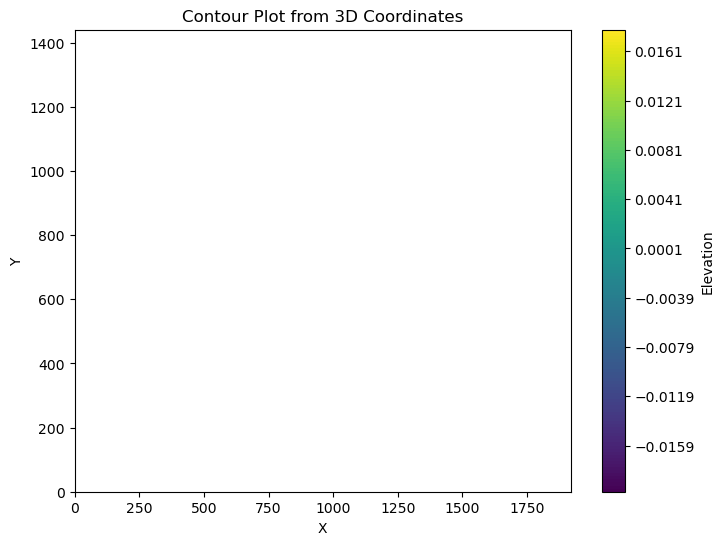

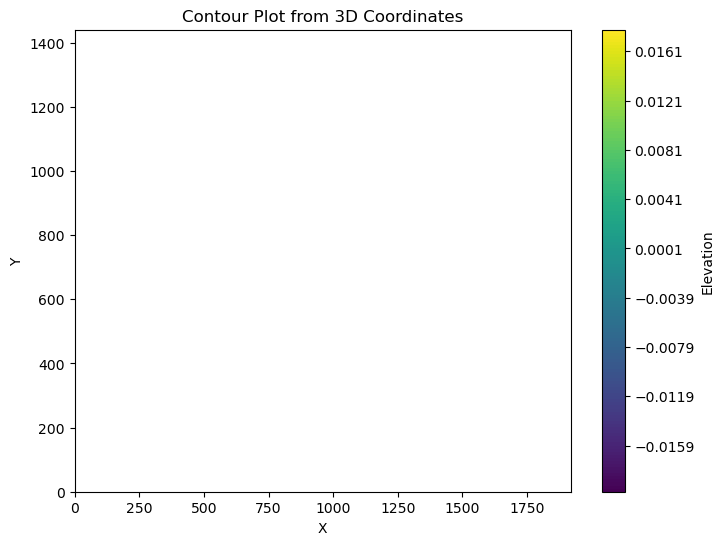

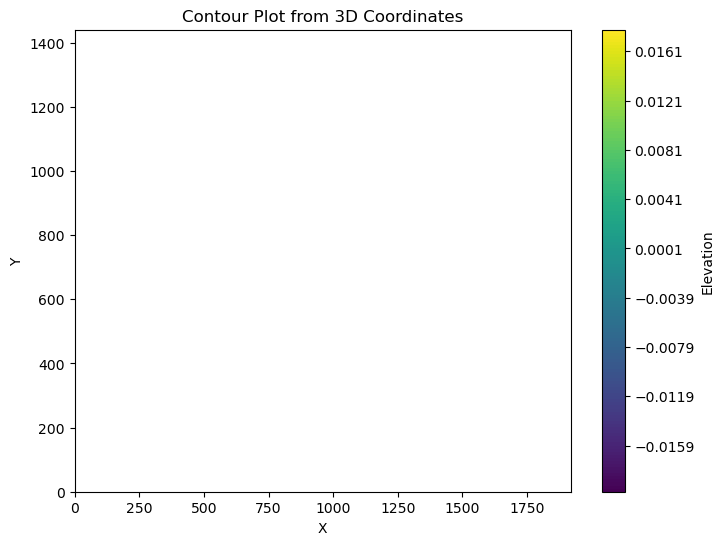

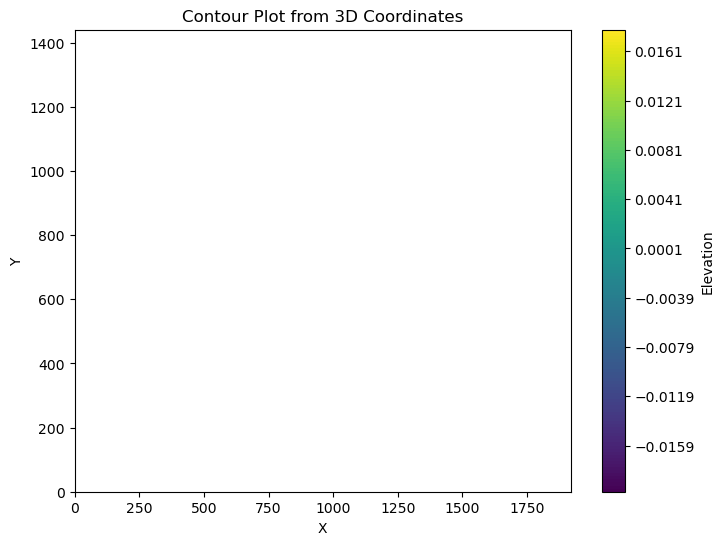

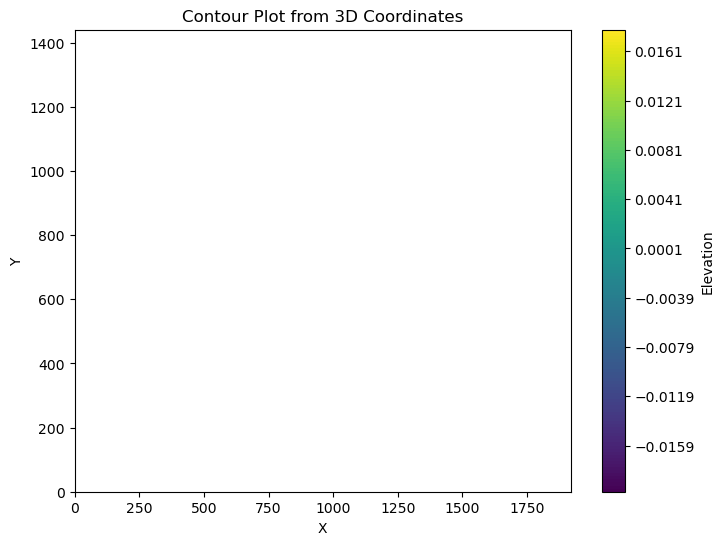

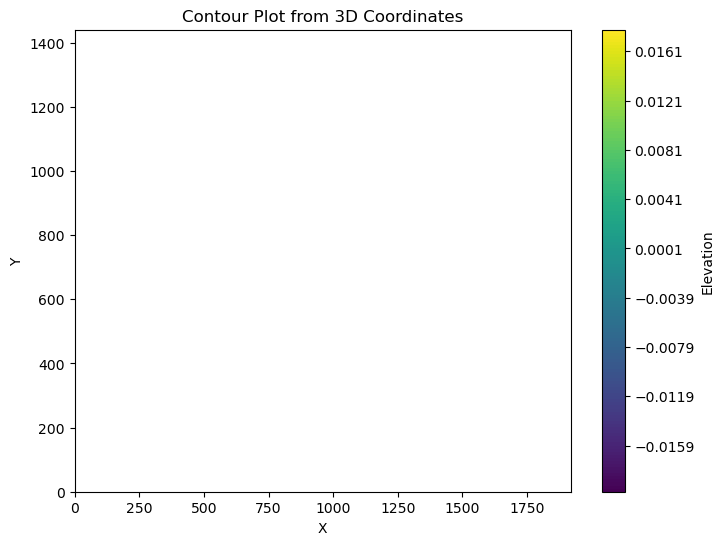

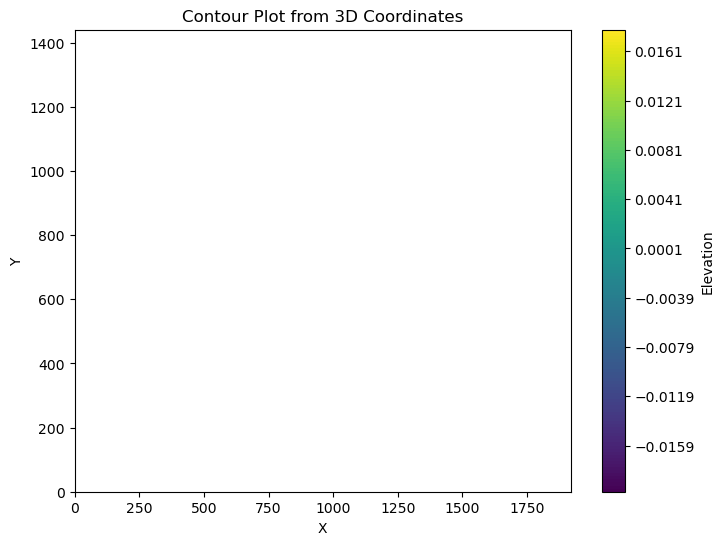

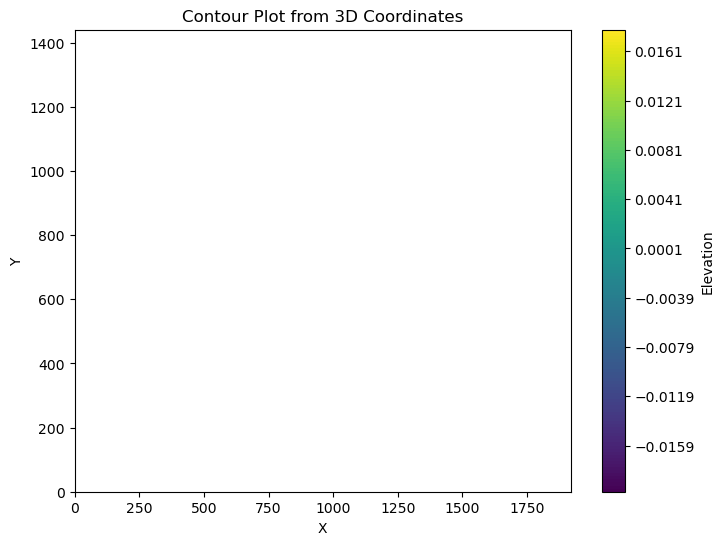

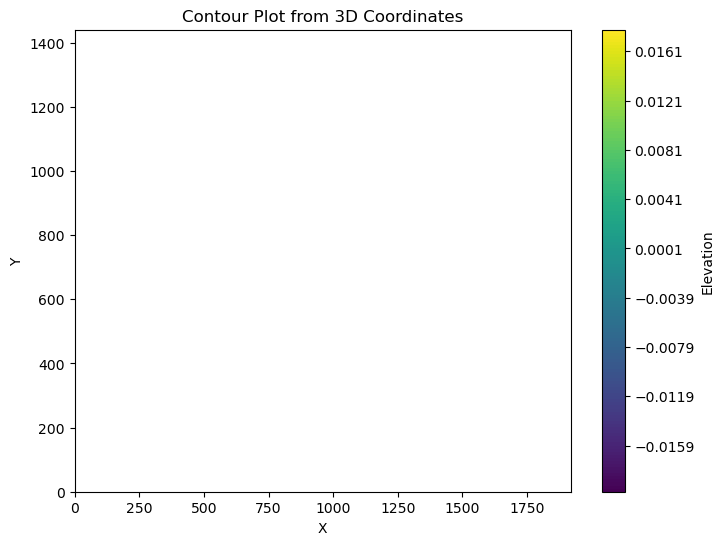

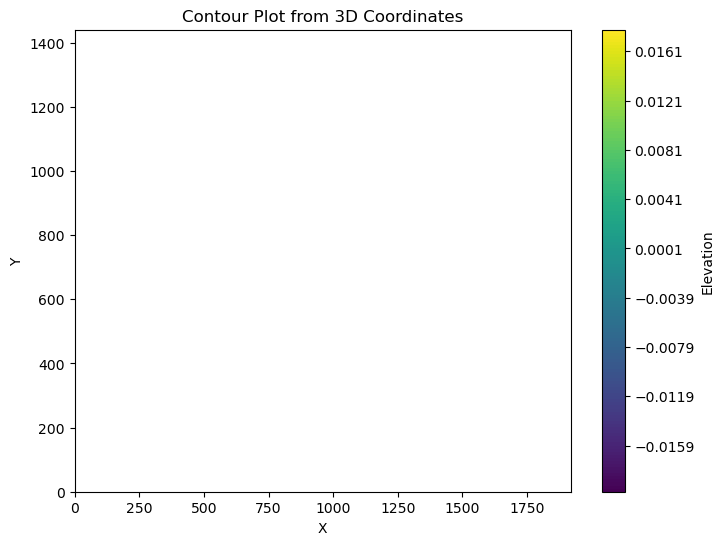

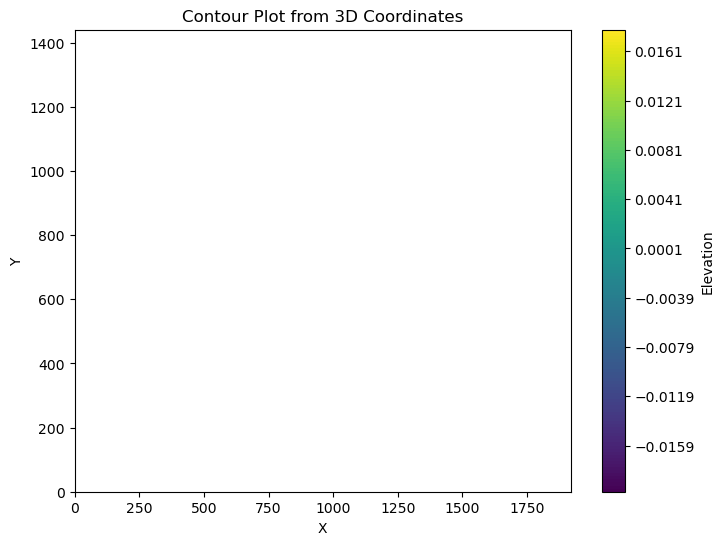

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
frame_width, frame_height = frame_width, frame_height
Levels = np.arange(smallest_strain, largest_strain, 0.00025)
for iter in range(len(Elements)):
    print(iter)
    x = []
    y = []
    z = []
    for i in Centroids[iter]:
        x.append(i[0])
    for i in Centroids[iter]:
        y.append(frame_height+i[1])
    for i in Elements[iter]:
        z.append(i[1][1])



    # Creating a grid for interpolation
    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolating z values for the grid
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    
    # Plotting contour plot
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(xi, yi, zi, levels=Levels, cmap='viridis')  # Adjust levels for contour density, cmap for colormap
    plt.colorbar(contour, label='Elevation')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0, frame_width)
    plt.ylim(0, frame_height)
    #plt.xlim(850, 1000)
    #plt.ylim(500, 1150)
    plt.title('Contour Plot from 3D Coordinates')
    plt.savefig(f"eachFrame/frame{iter}.png")


import cv2
import numpy as np
import glob
img_array = []
for x in range(len(Elements)):
   filename = f'eachFrame/frame{x}.png'
   img = cv2.imread(filename)
   height, width, layers = img.shape
   size = (width,height)
   img_array.append(img)

out = cv2.VideoWriter('video10.avi',cv2.VideoWriter_fourcc(*'DIVX'), 14, size)

for i in range(len(img_array)):
   out.write(img_array[i])
out.release()
print(Distance)